In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-15 08:59:21.173423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744696761.197212   60487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744696761.203570   60487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744696761.218808   60487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744696761.218841   60487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744696761.218843   60487 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
precision_1000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/1000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/1000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        precision_1000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(precision_1000).transpose().to_dict()
    print()
    with open('results_1000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_1000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_1000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_1000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
7995,1.245453,84831.8,6.0,62.3,59.269257,59.269257,0.0,0.0,0.0,0.0,...,529.760119,623.2,1.879692e-03,5.5,44.798738,749.193946,352519.133101,0.8,38.5,Bruteforce
7996,1.549077,1116.1,7.1,82.0,184.752583,184.752583,0.0,0.0,0.0,0.0,...,472.746293,214.9,1.666013e+08,13.5,26.110301,670.027076,225374.808644,1.0,244.6,Bruteforce
7997,1928.654402,69985.6,9.8,89.0,0.444028,0.444028,0.0,0.0,0.0,0.0,...,53.597589,108.2,2.198360e-02,5.5,13.710583,75.798437,3803.107186,0.8,38.5,Bruteforce
7998,7.056125,1005.2,6.0,62.2,6.904529,6.904529,0.0,0.0,0.0,0.0,...,83.988279,130.8,1.156039e-02,5.5,16.163288,118.777363,8923.574843,0.9,38.5,Bruteforce
7999,588.626037,45848.8,7.6,139.4,5.227422,5.227422,0.0,0.0,0.0,0.0,...,56.285161,112.7,3.807089e-02,5.5,13.779049,79.599238,3903.543166,0.9,38.5,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0             DDoS
1             DDoS
2             DDoS
3             DDoS
4             DDoS
           ...    
7995    Bruteforce
7996    Bruteforce
7997    Bruteforce
7998    Bruteforce
7999    Bruteforce
Name: Attack Type, Length: 8000, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6800, 46), (6800,), (1200, 46), (1200,))

# K Nearest Neighbour

In [16]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 103 ms, sys: 13.8 ms, total: 117 ms
Wall time: 60.4 ms


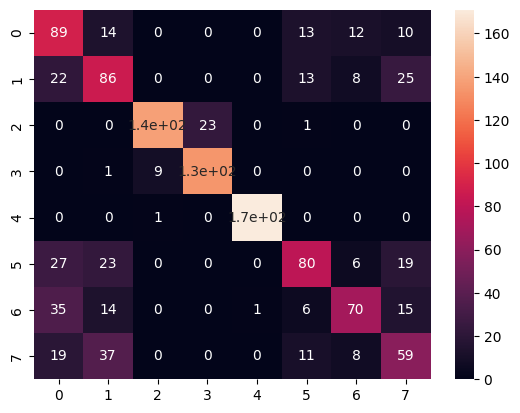

In [17]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [18]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [19]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [20]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [21]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.53558,0.060391


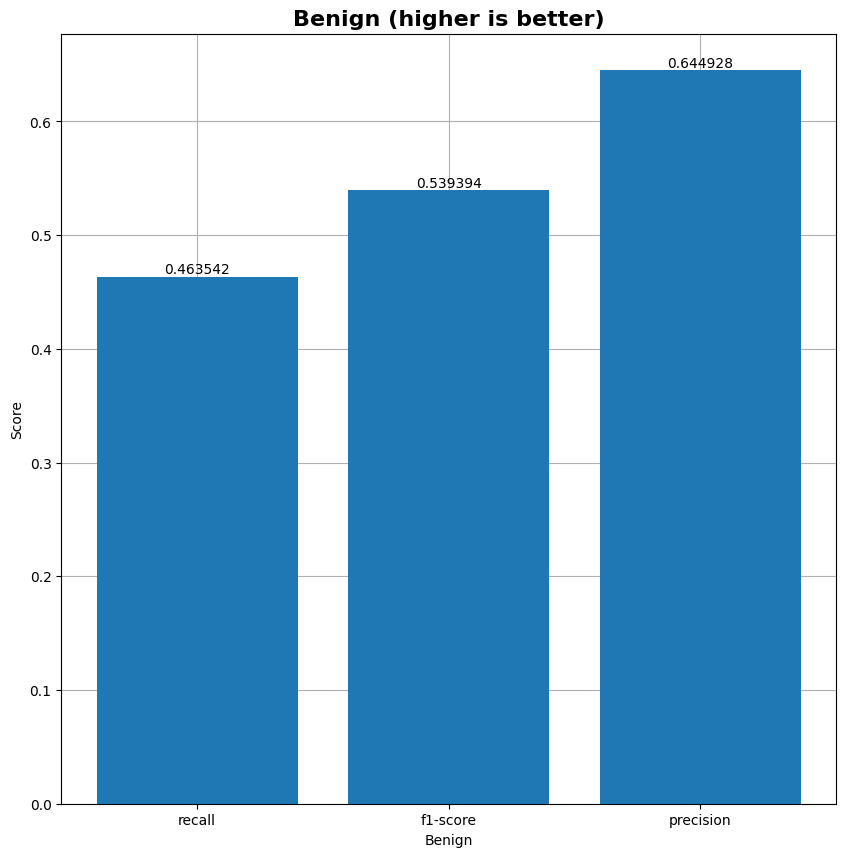

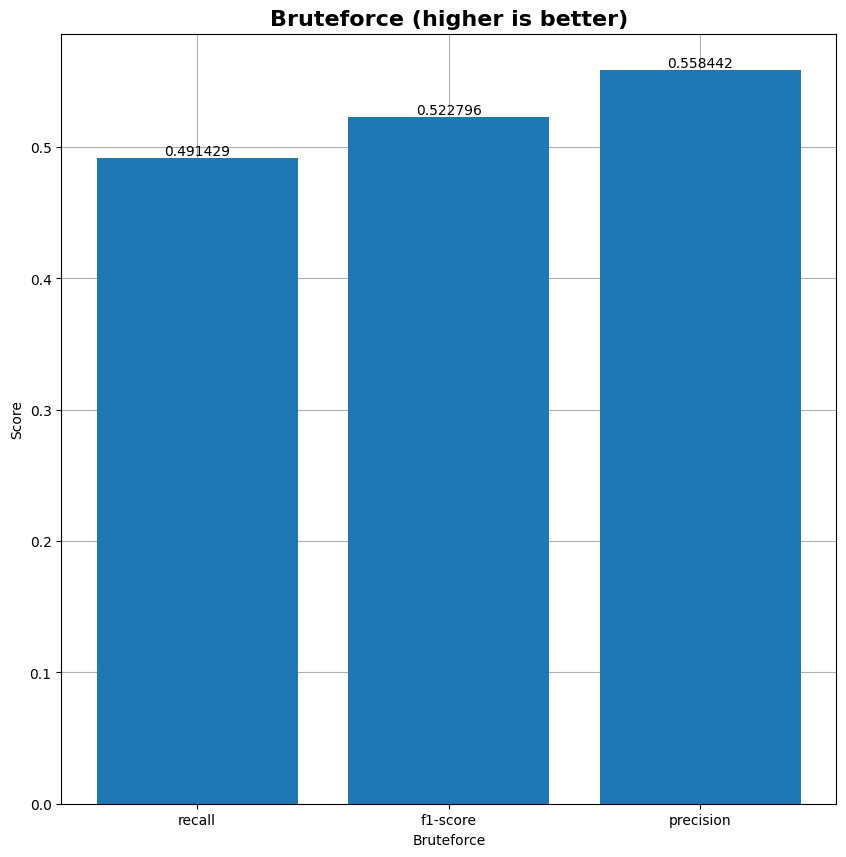

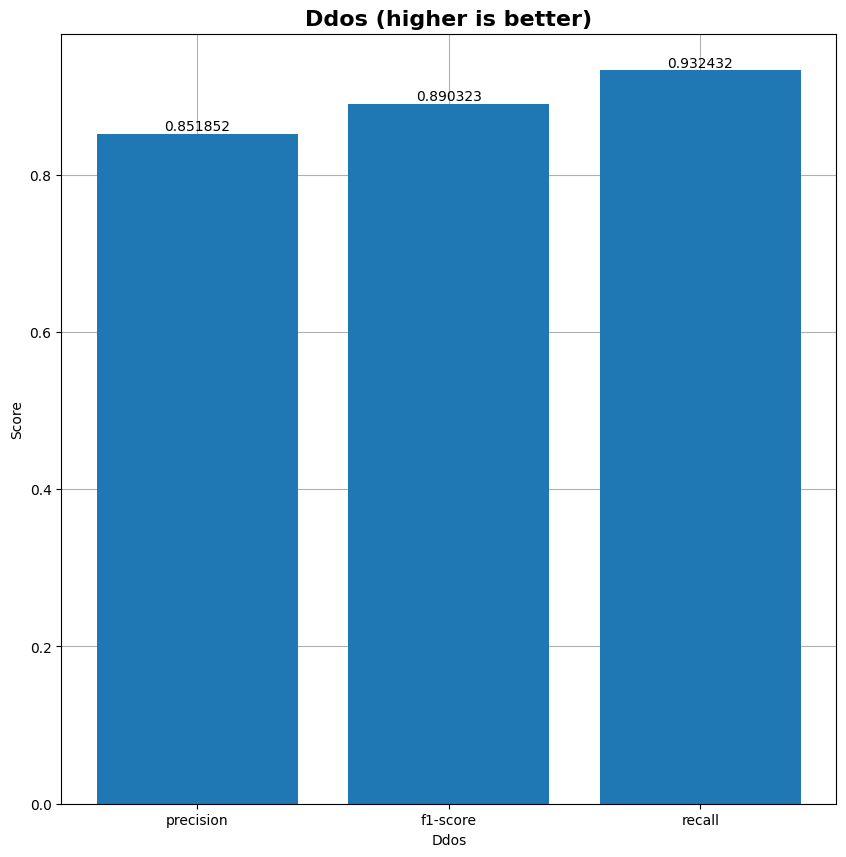

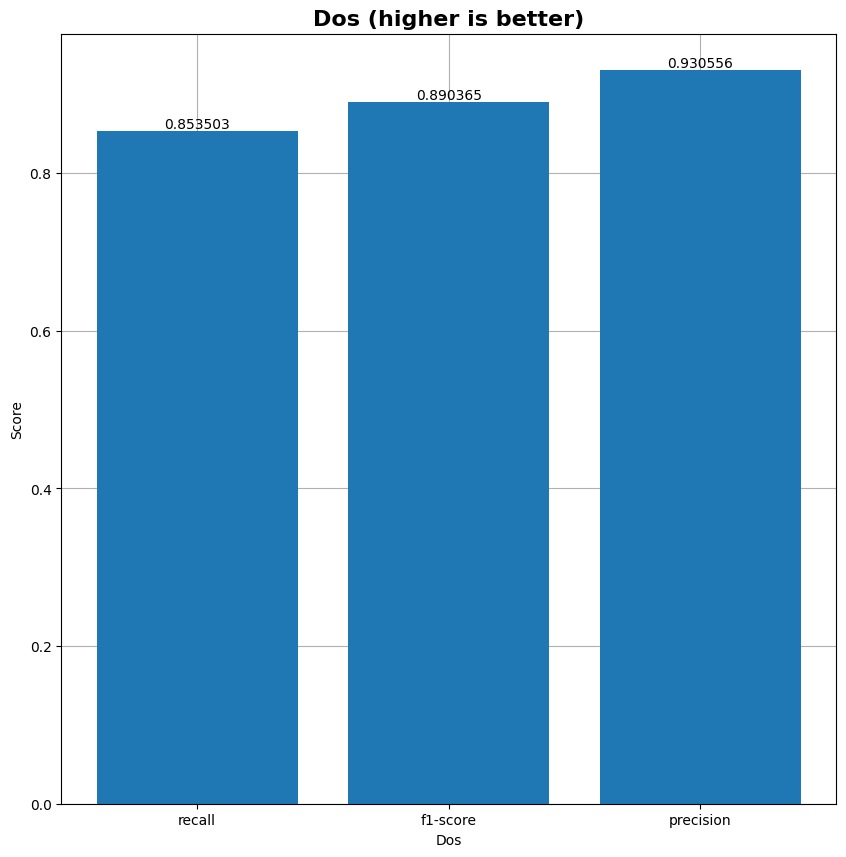

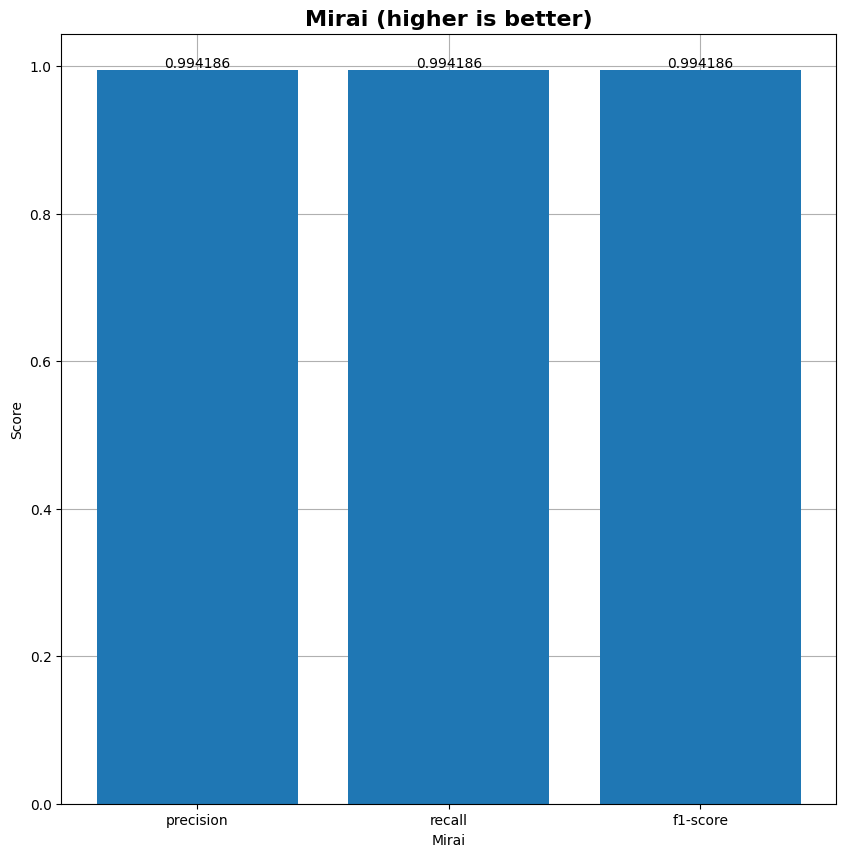

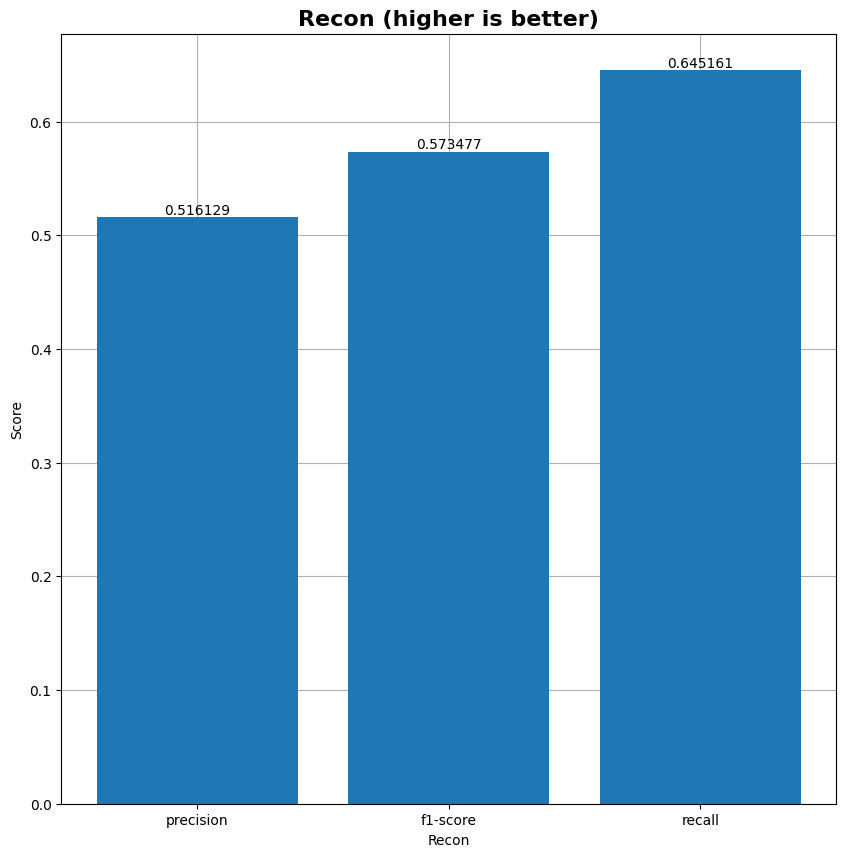

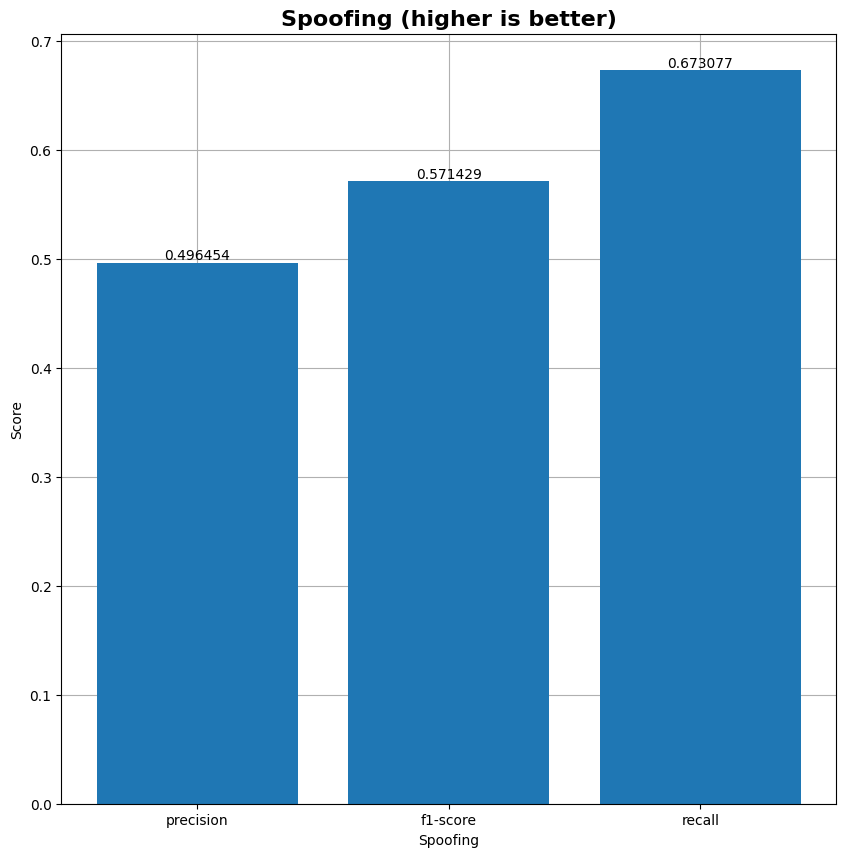

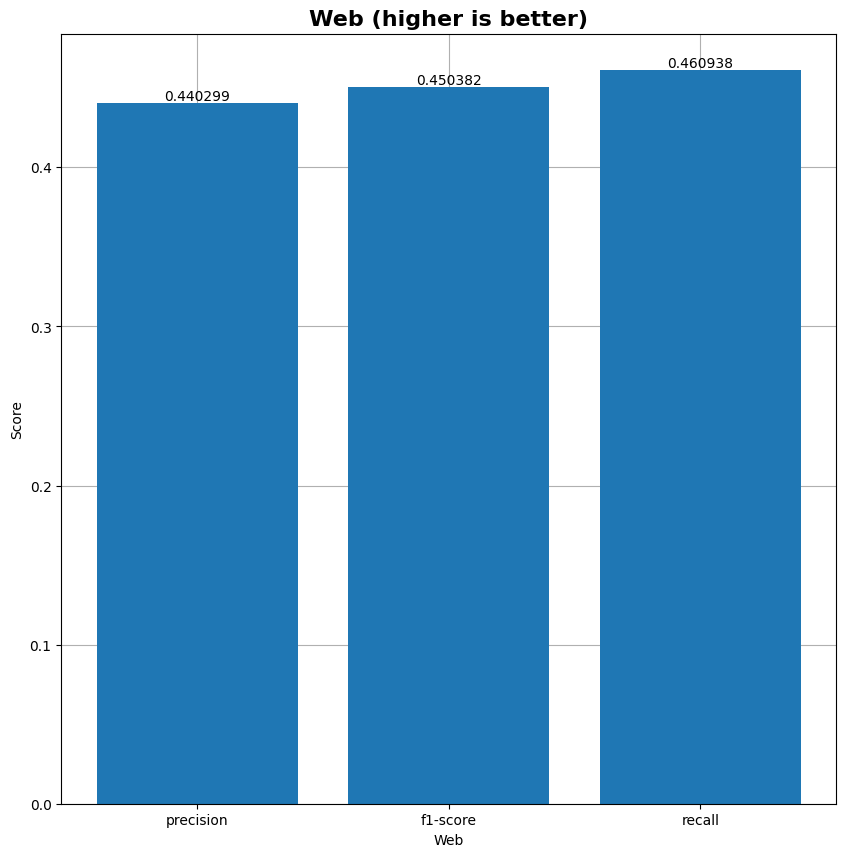

In [22]:
plot_mc(y_pred, y_test, "kNN")

In [23]:
model_name = "kNN_1000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Logistic Regression

In [24]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

CPU times: user 7.07 s, sys: 21.8 ms, total: 7.1 s
Wall time: 7.16 s


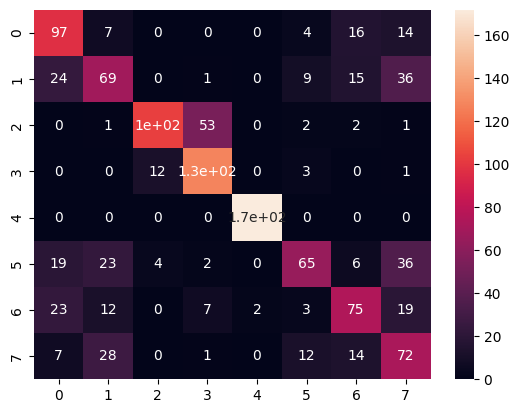

In [25]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [26]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [27]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LR_time]
results_dict["LR"] = results

In [28]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [29]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463


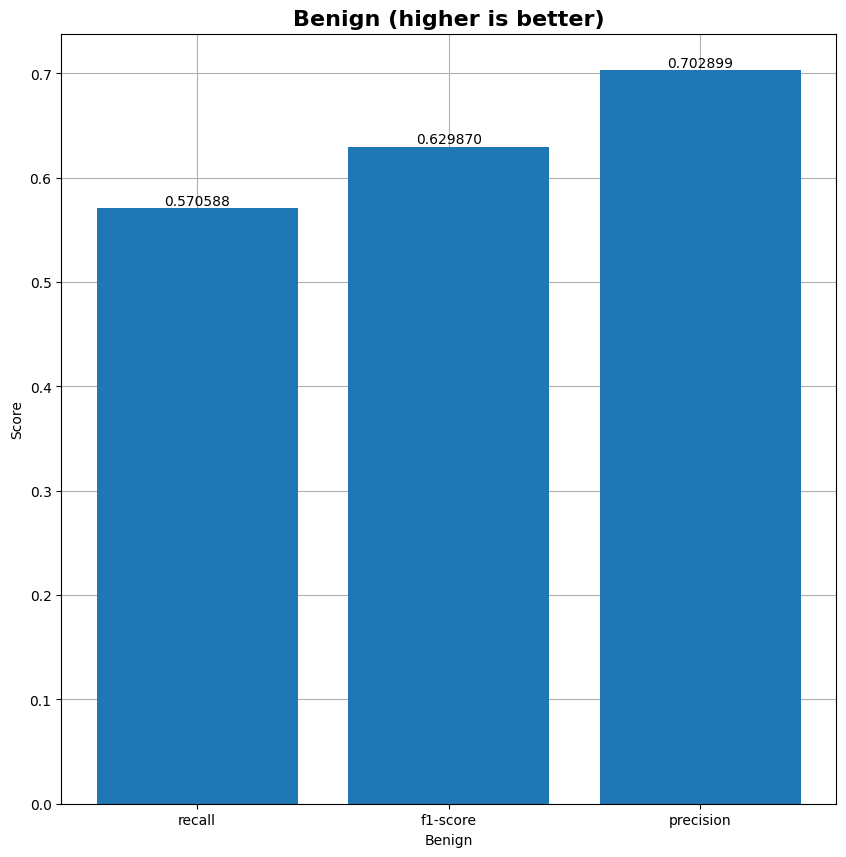

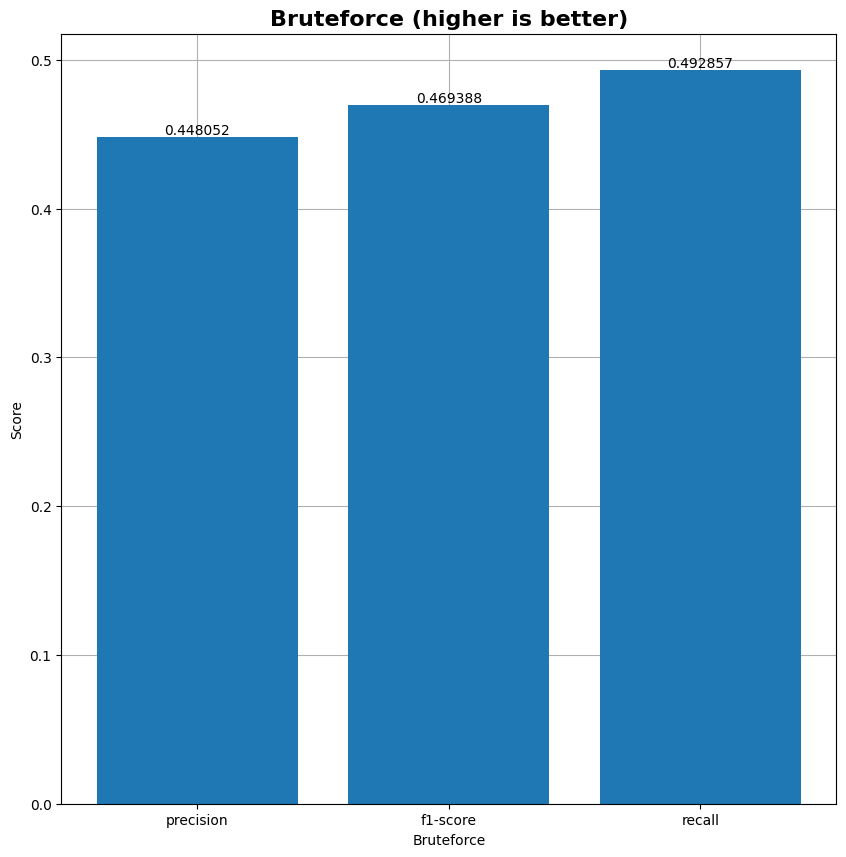

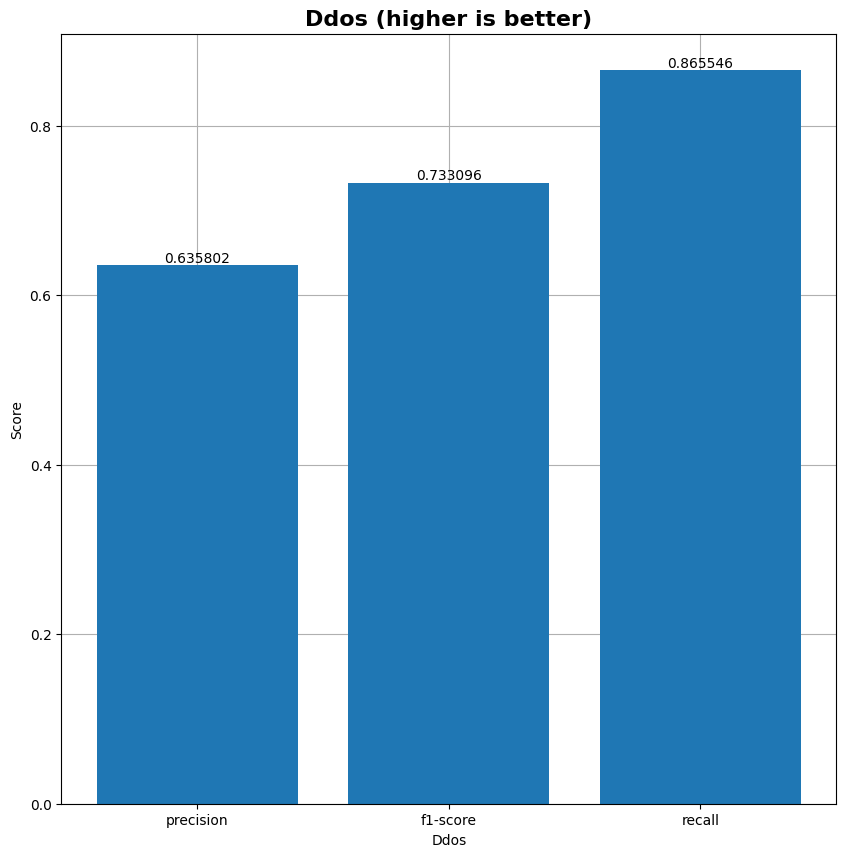

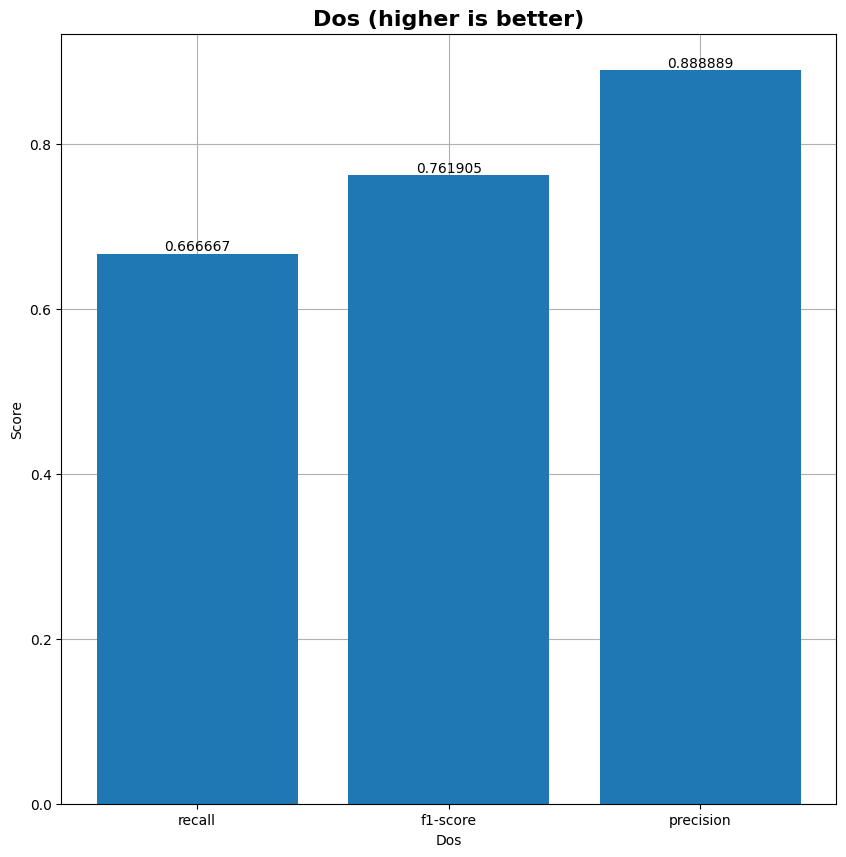

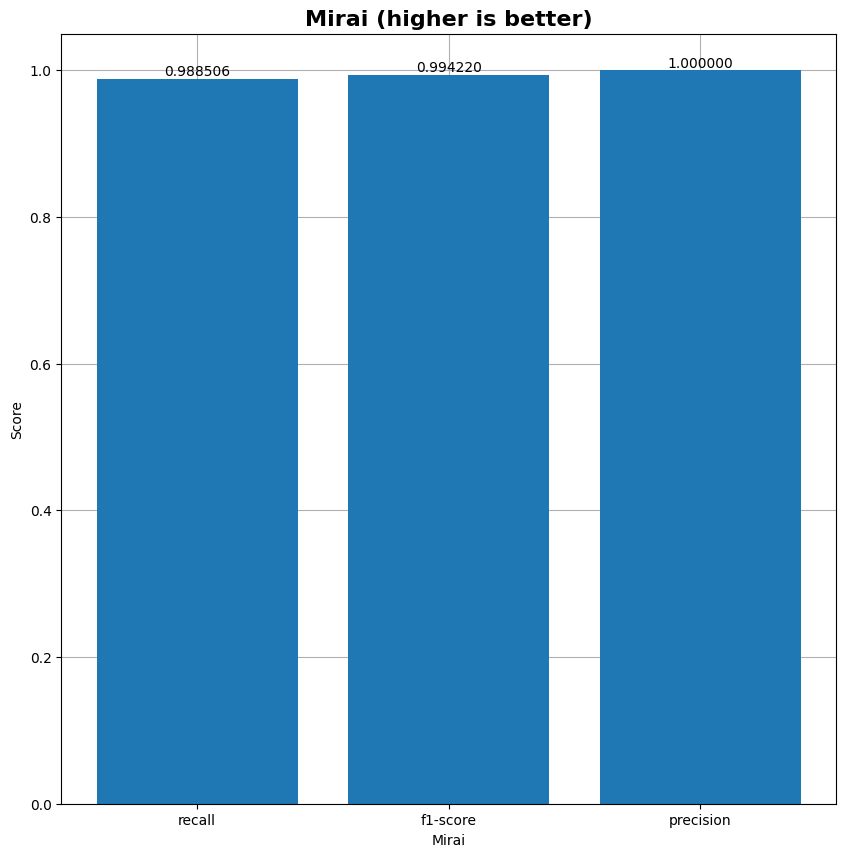

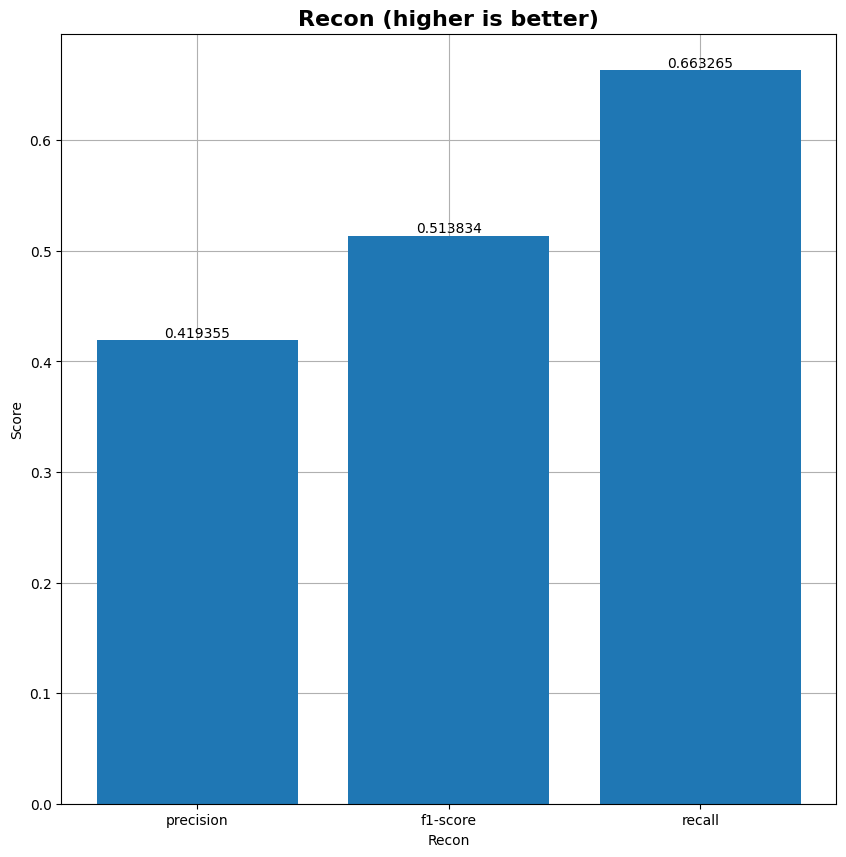

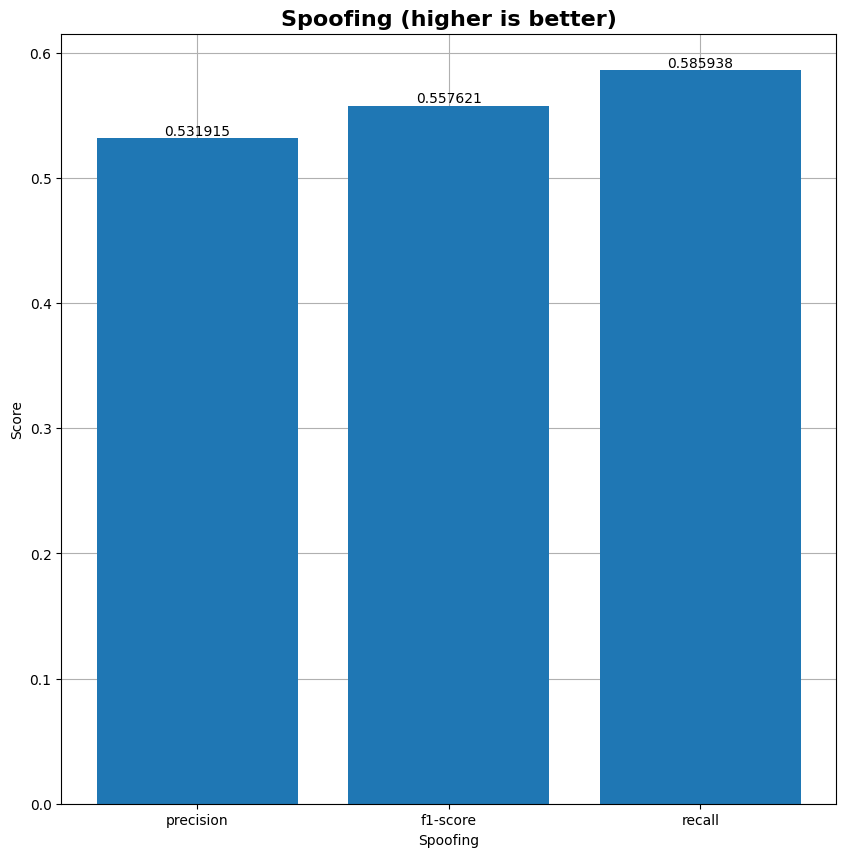

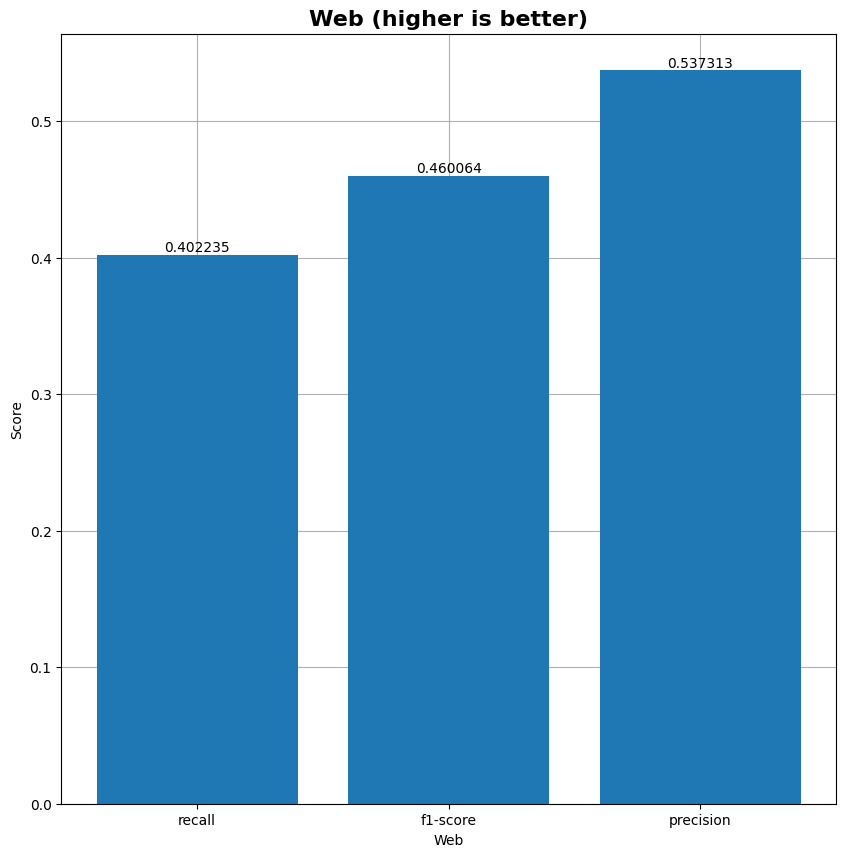

In [30]:
plot_mc(y_pred, y_test, "LR")

In [31]:
model_name = "LR_1000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [32]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 2.08 s, sys: 54.5 ms, total: 2.14 s
Wall time: 447 ms


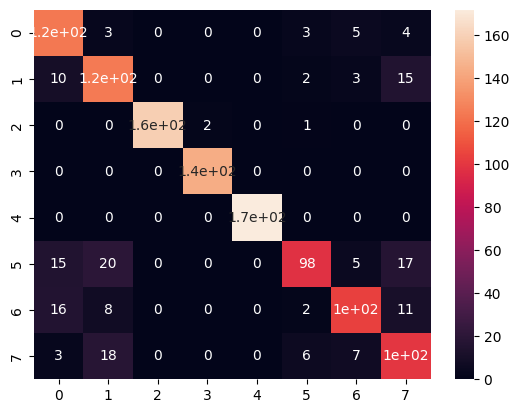

In [33]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [34]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [35]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [36]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [37]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463
RF,0.853333,0.860908,0.852851,0.853333,0.833467,0.579167,2.920833,1.709045,0.446966


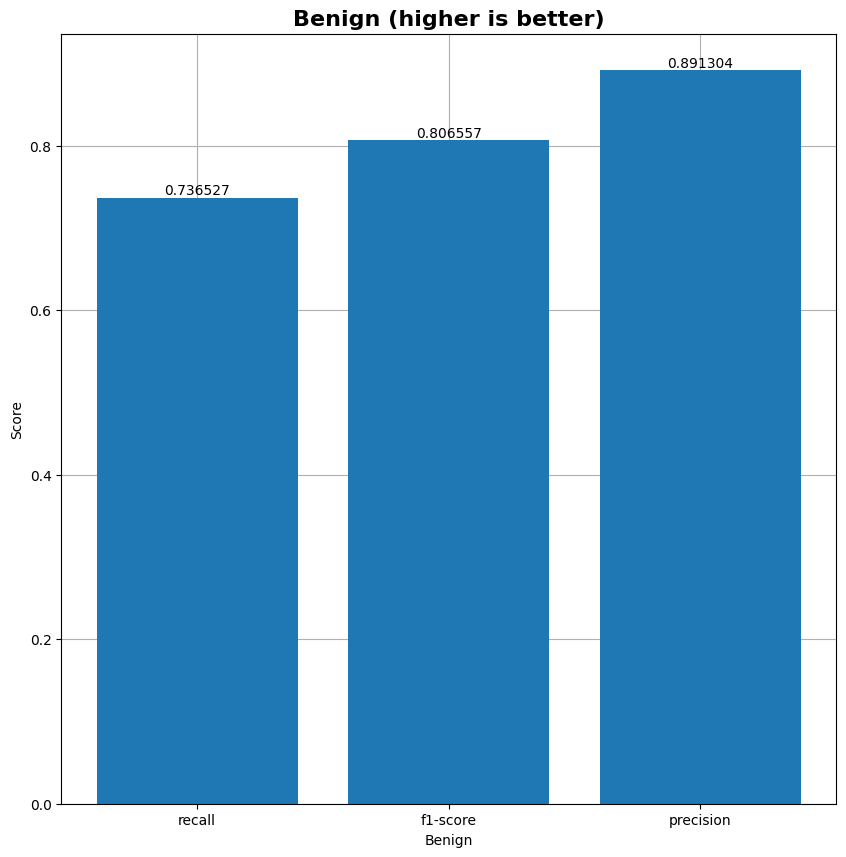

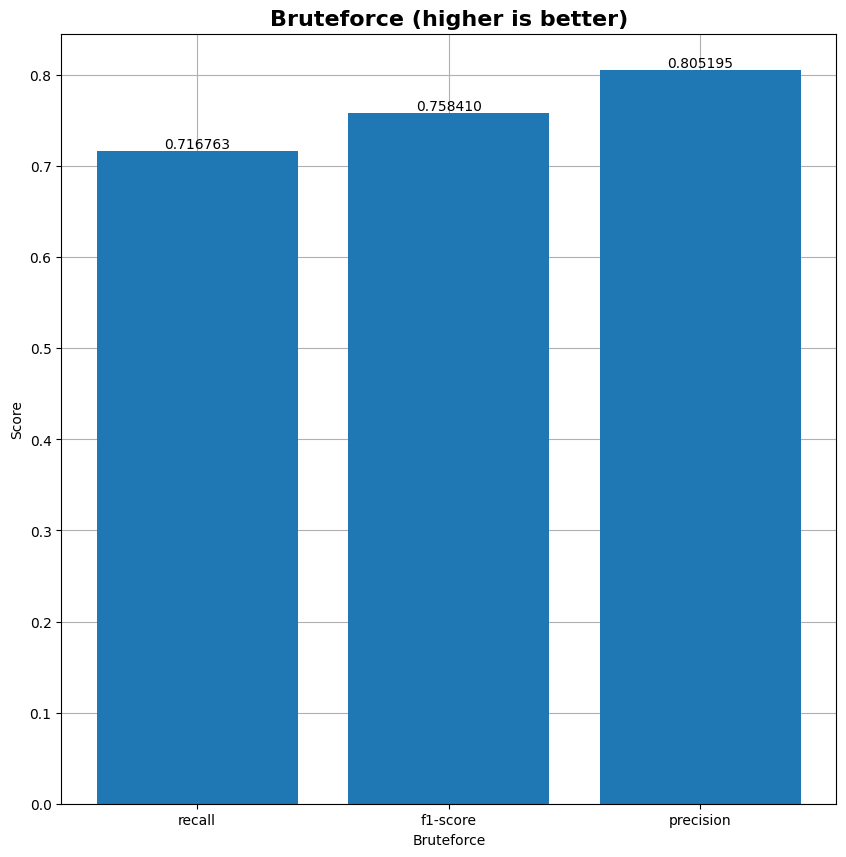

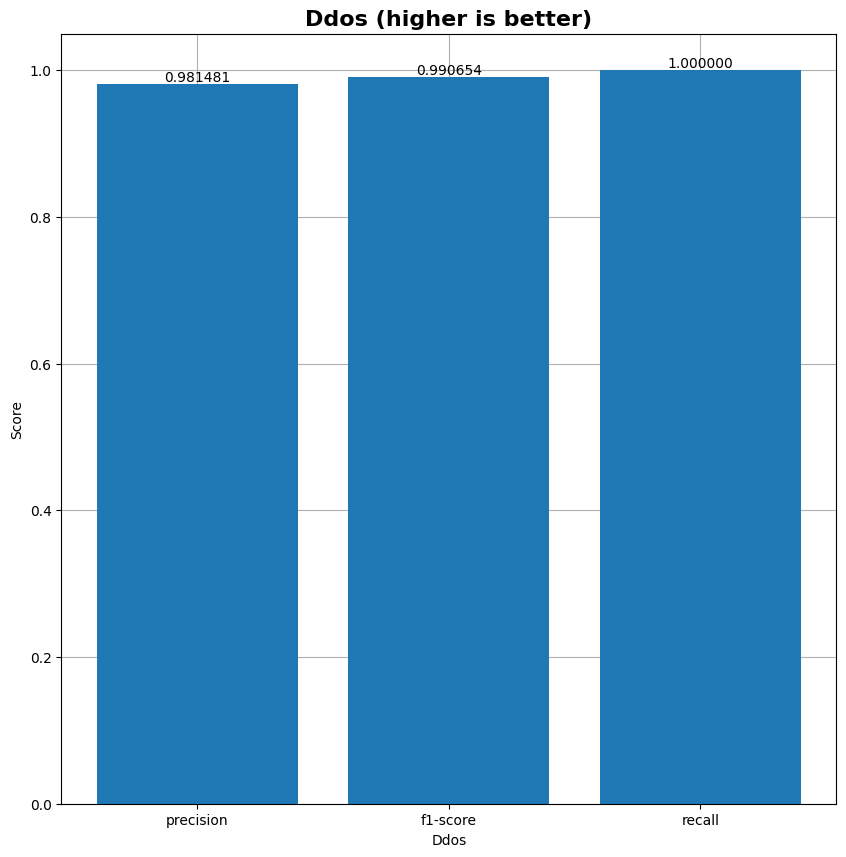

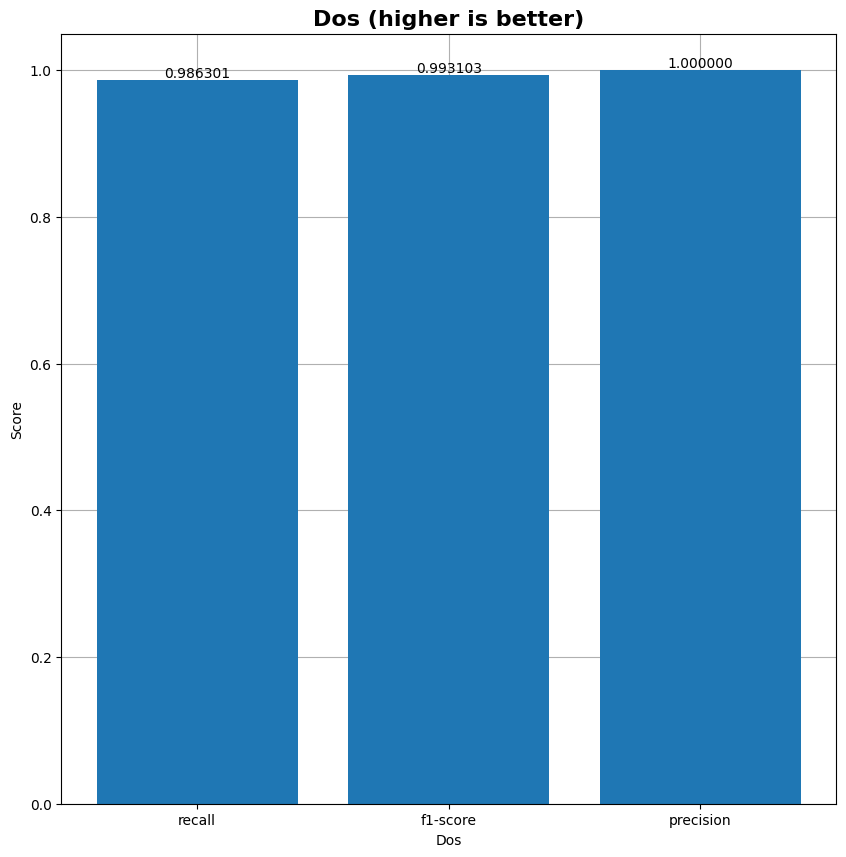

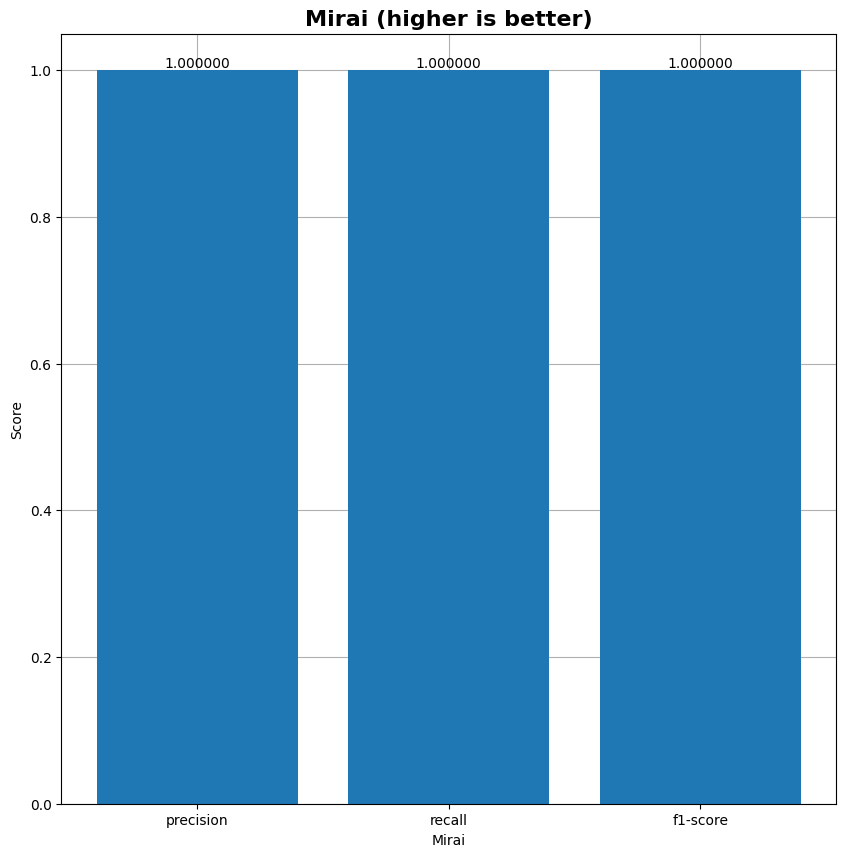

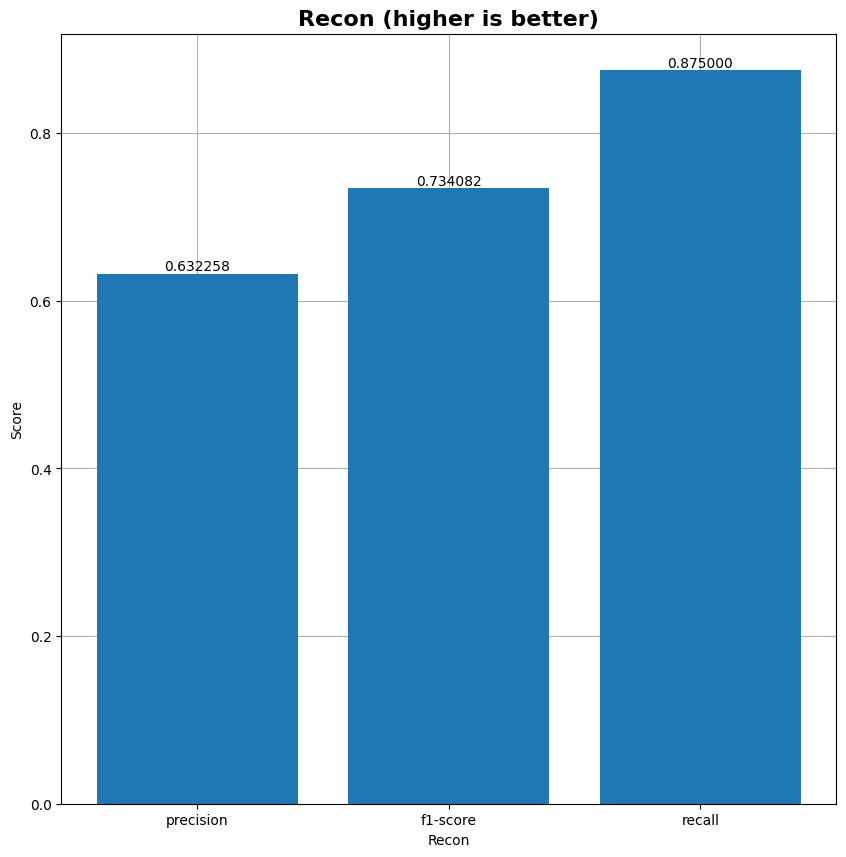

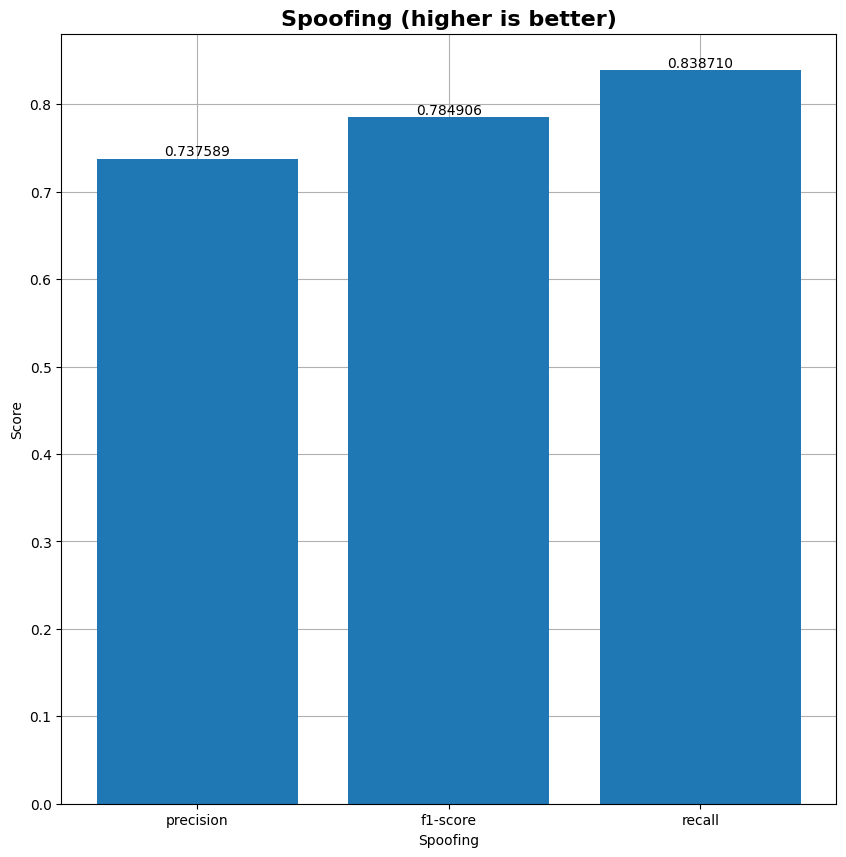

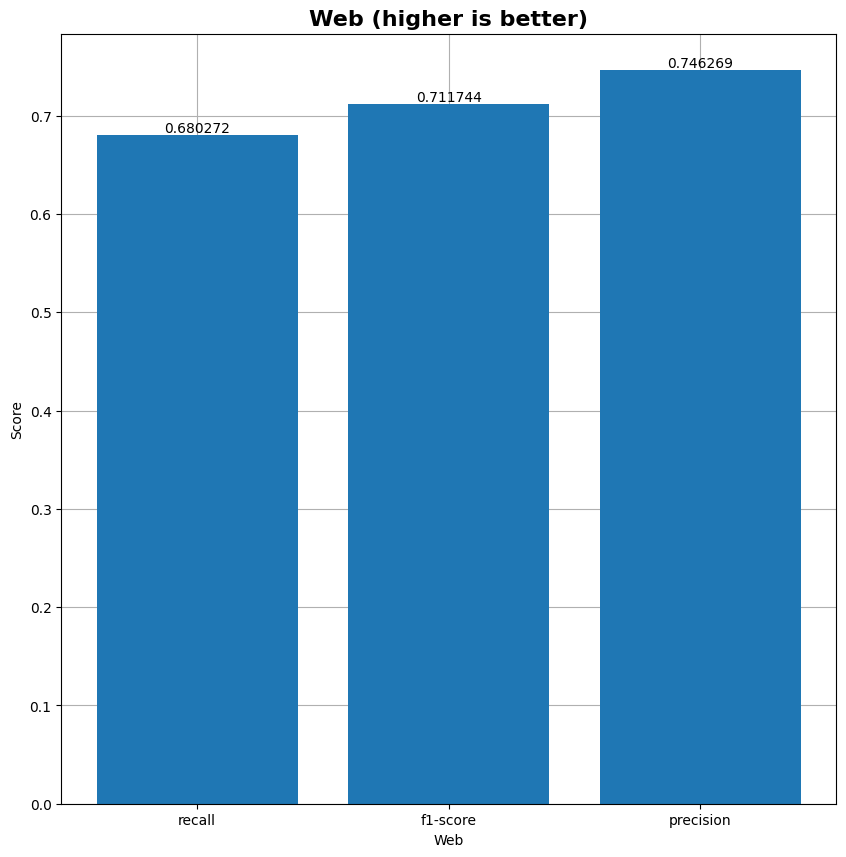

In [38]:
plot_mc(y_pred, y_test, "RF")

In [39]:
model_name = "RF_1000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [40]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 20.9 s, sys: 145 ms, total: 21.1 s
Wall time: 3.43 s


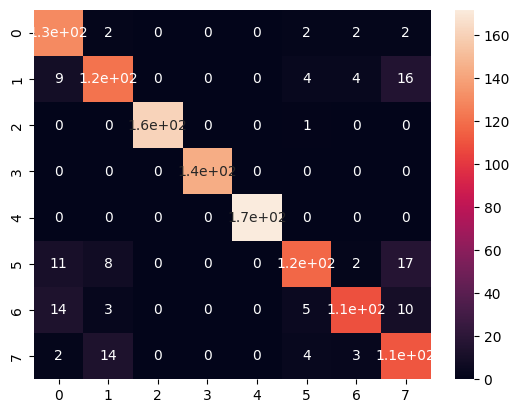

In [41]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [42]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [43]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [44]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [45]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463
RF,0.853333,0.860908,0.852851,0.853333,0.833467,0.579167,2.920833,1.709045,0.446966
XGBoost,0.887500,0.893127,0.887680,0.887500,0.872146,0.440000,2.223333,1.491085,3.434732


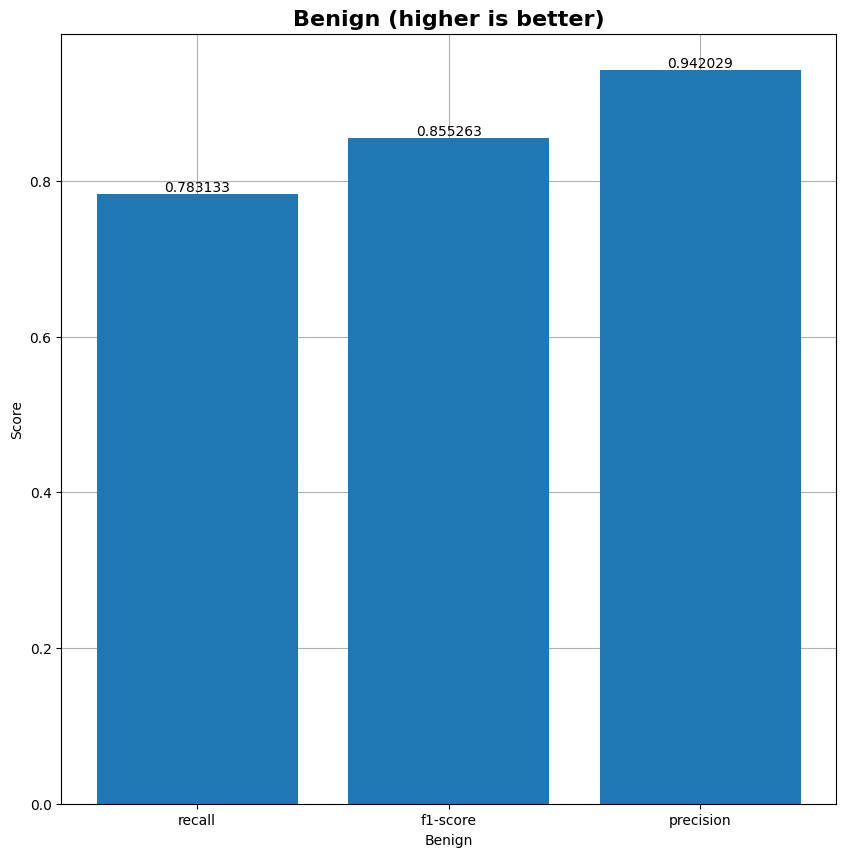

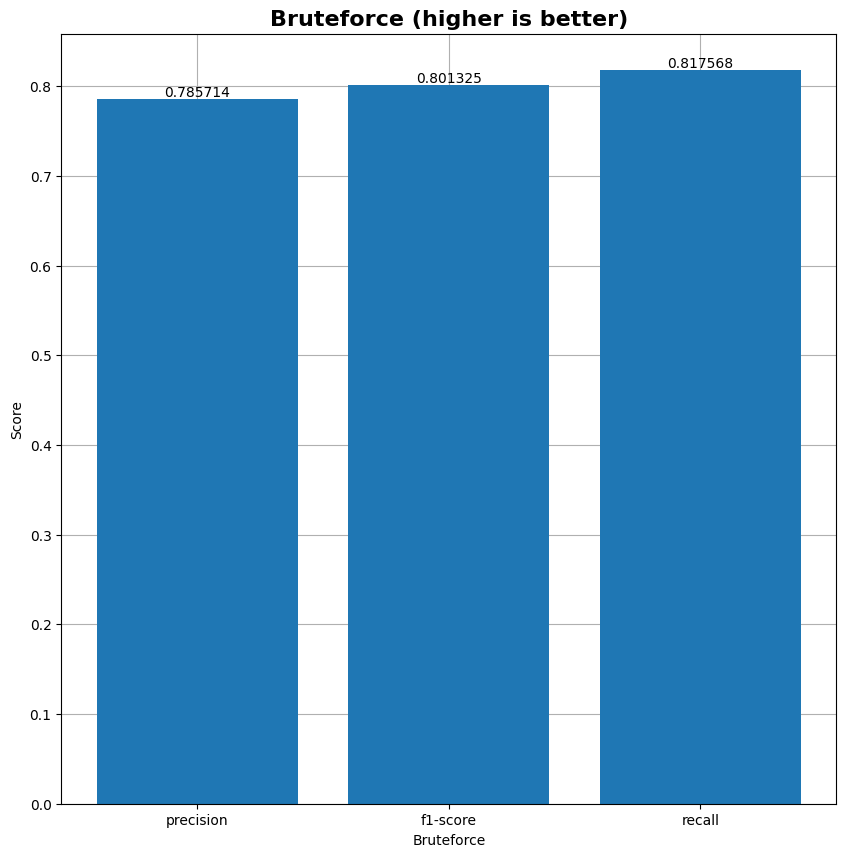

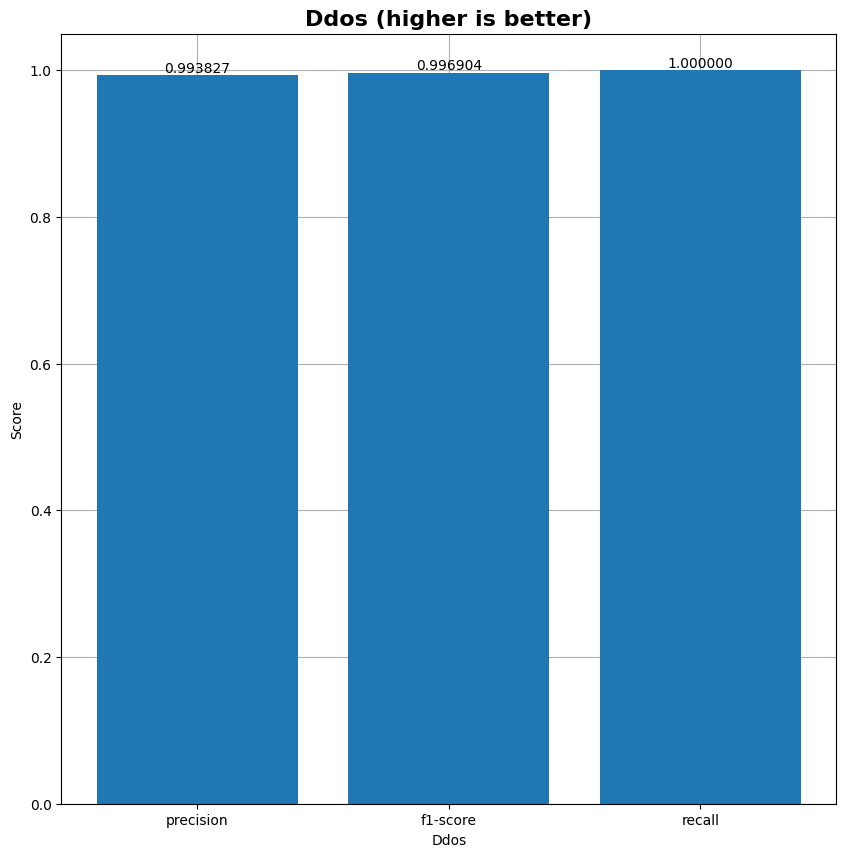

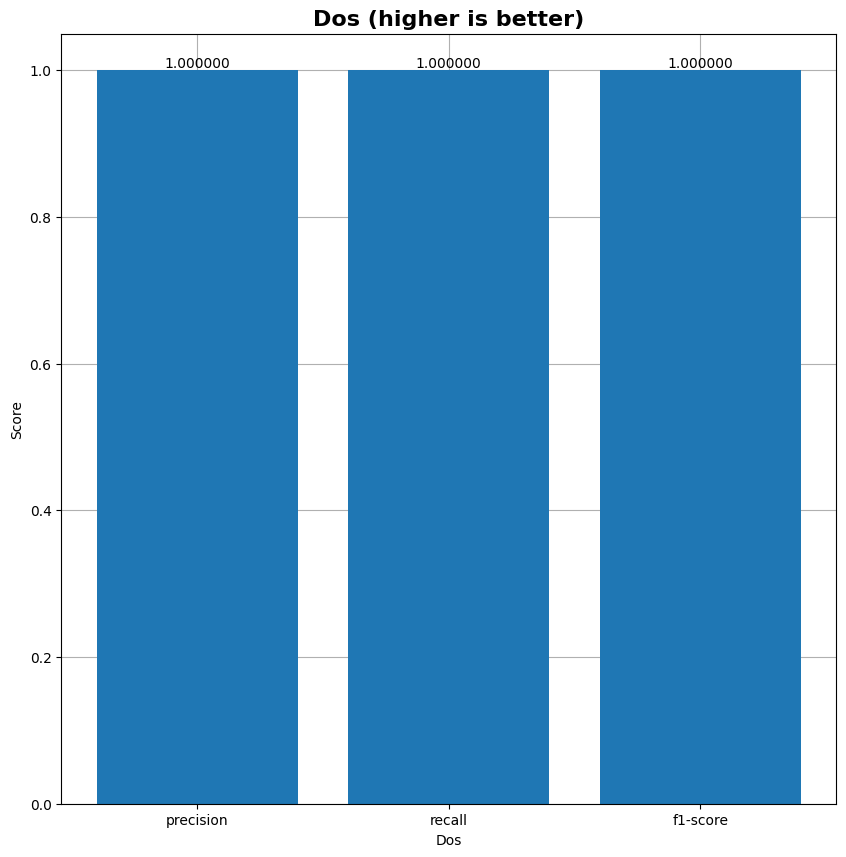

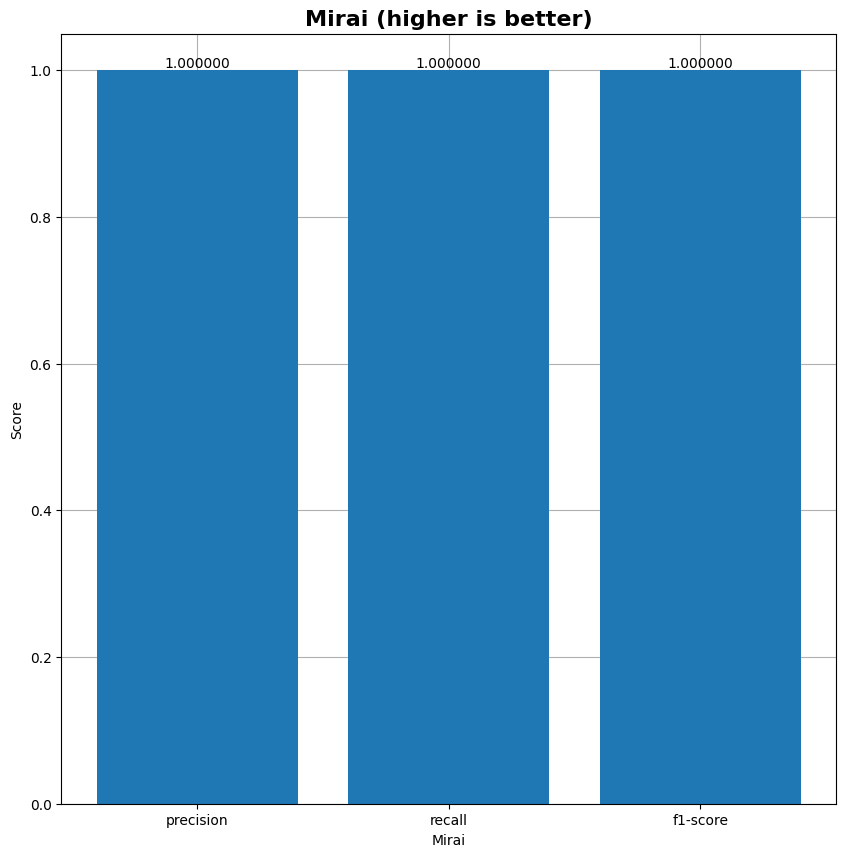

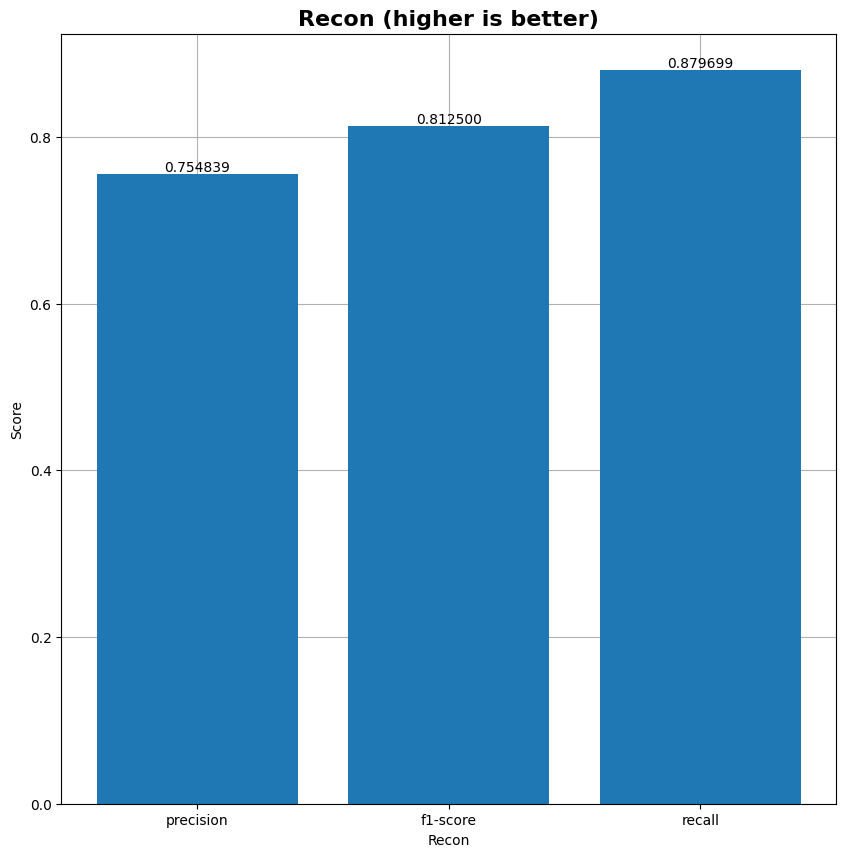

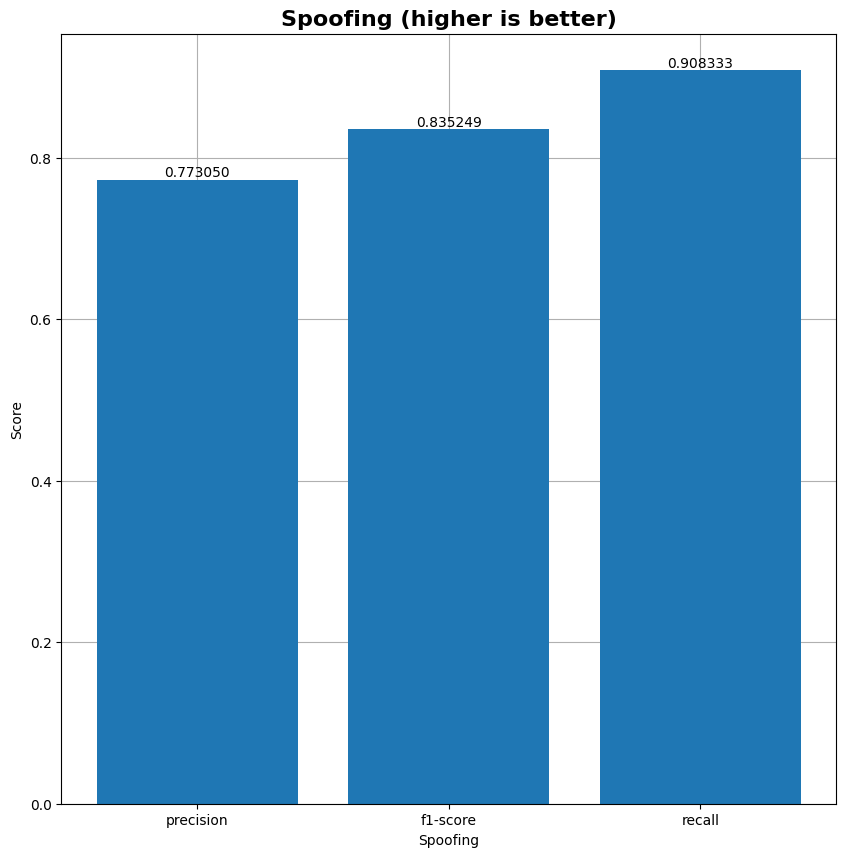

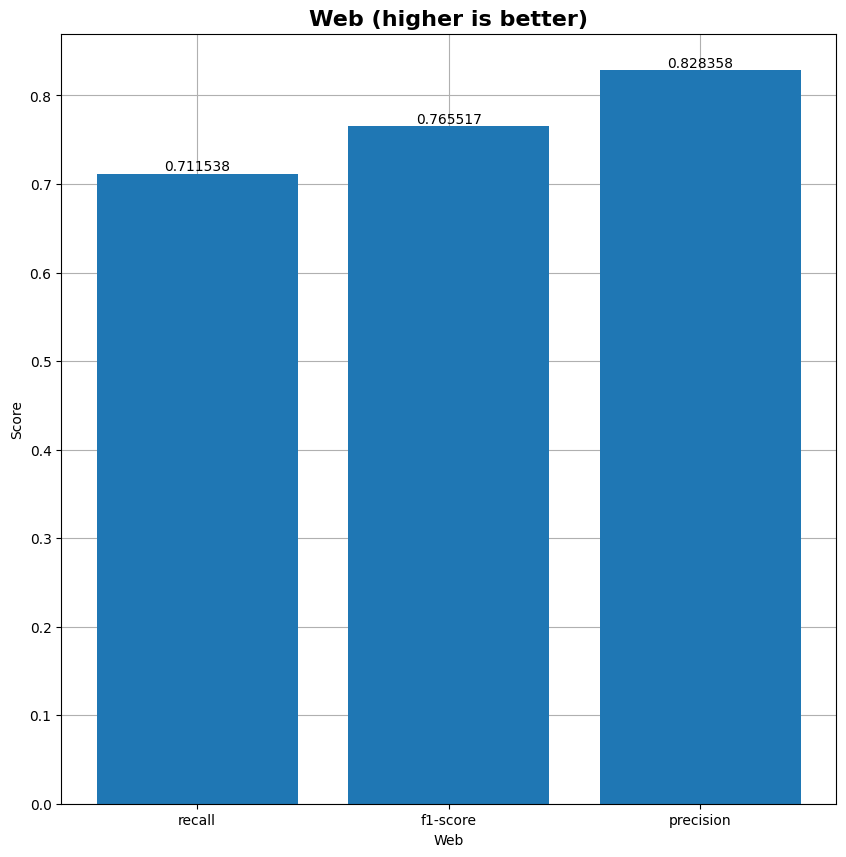

In [46]:
plot_mc(y_pred, y_test, "XGBoost")

In [47]:
model_name = "XGB_1000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [48]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4855
[LightGBM] [Info] Number of data points in the train set: 6800, number of used features: 36
[LightGBM] [Info] Start training from score -2.065423
[LightGBM] [Info] Start training from score -2.084159
[LightGBM] [Info] Start training from score -2.093660
[LightGBM] [Info] Start training from score -2.072408
[LightGBM] [Info] Start training from score -2.105665
[LightGBM] [Info] Start training from score -2.085341
[LightGBM] [Info] Start training from score -2.068909
[LightGBM] [Info] Start training from score -2.060793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


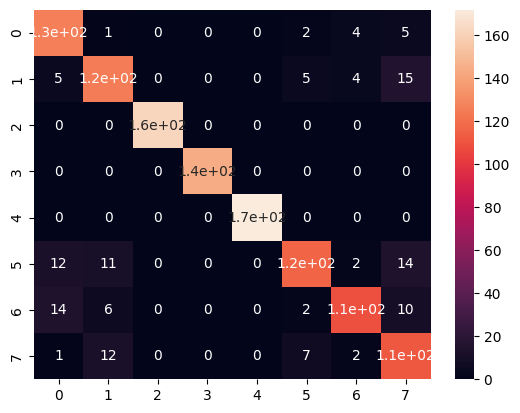

In [49]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [50]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [51]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [52]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [53]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463
RF,0.853333,0.860908,0.852851,0.853333,0.833467,0.579167,2.920833,1.709045,0.446966
XGBoost,0.887500,0.893127,0.887680,0.887500,0.872146,0.440000,2.223333,1.491085,3.434732
LightGBM,0.888333,0.893065,0.888502,0.888333,0.872943,0.466667,2.396667,1.548117,1.122775


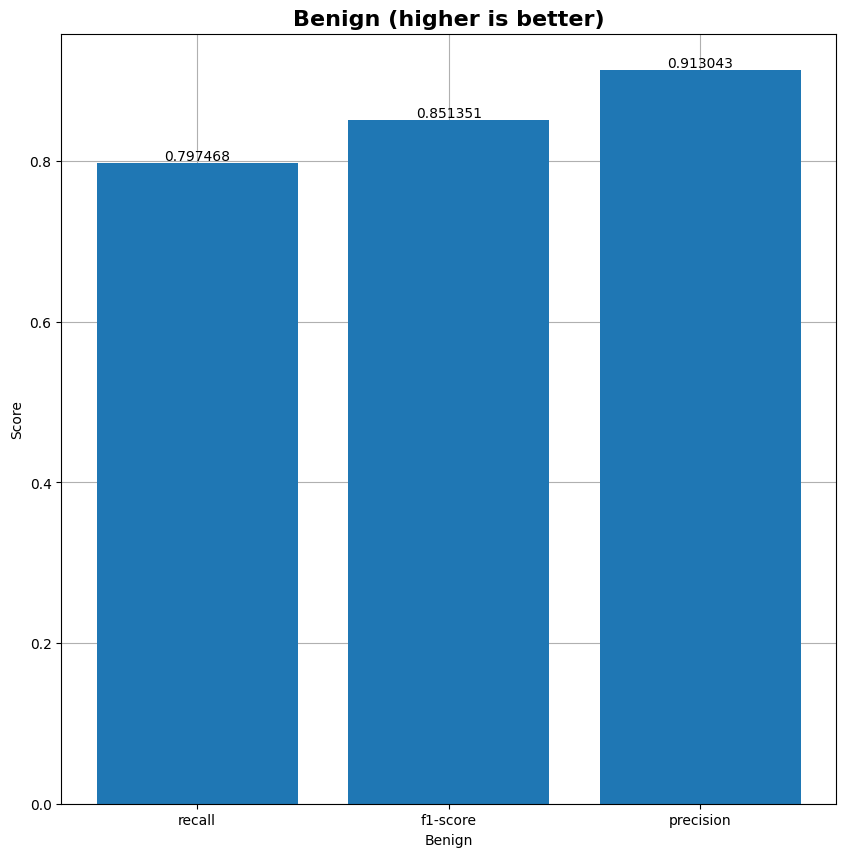

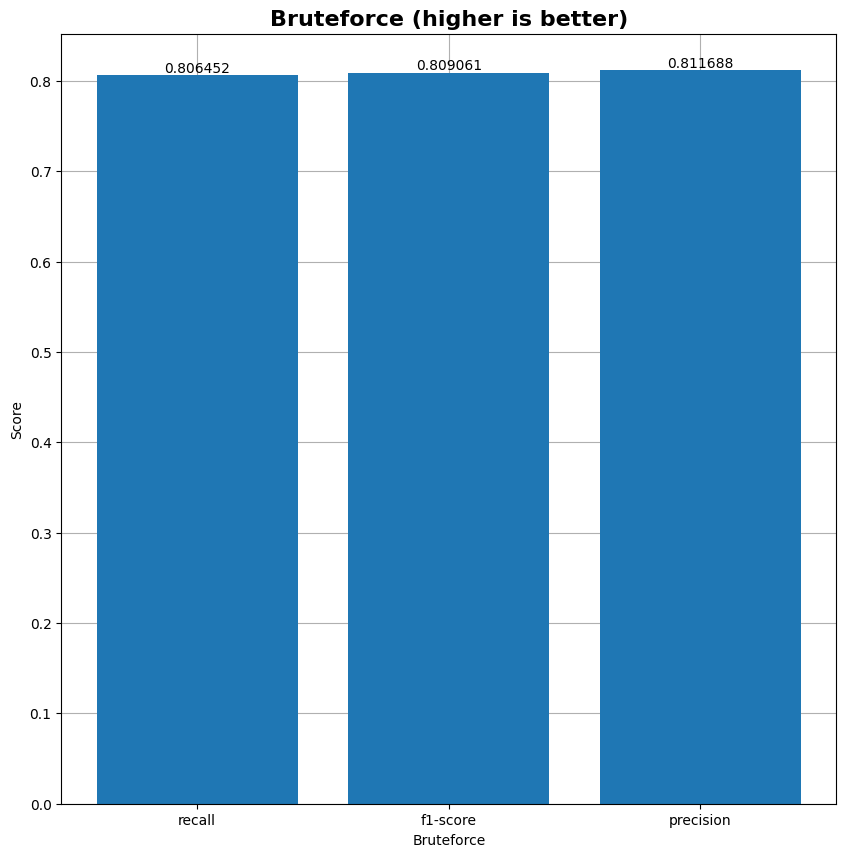

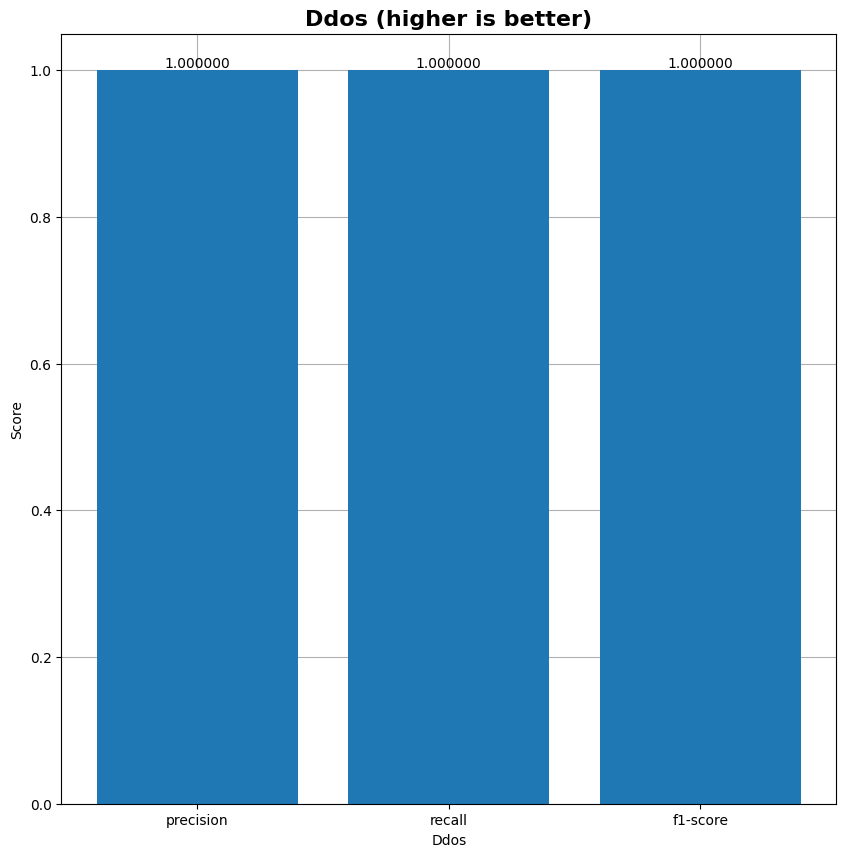

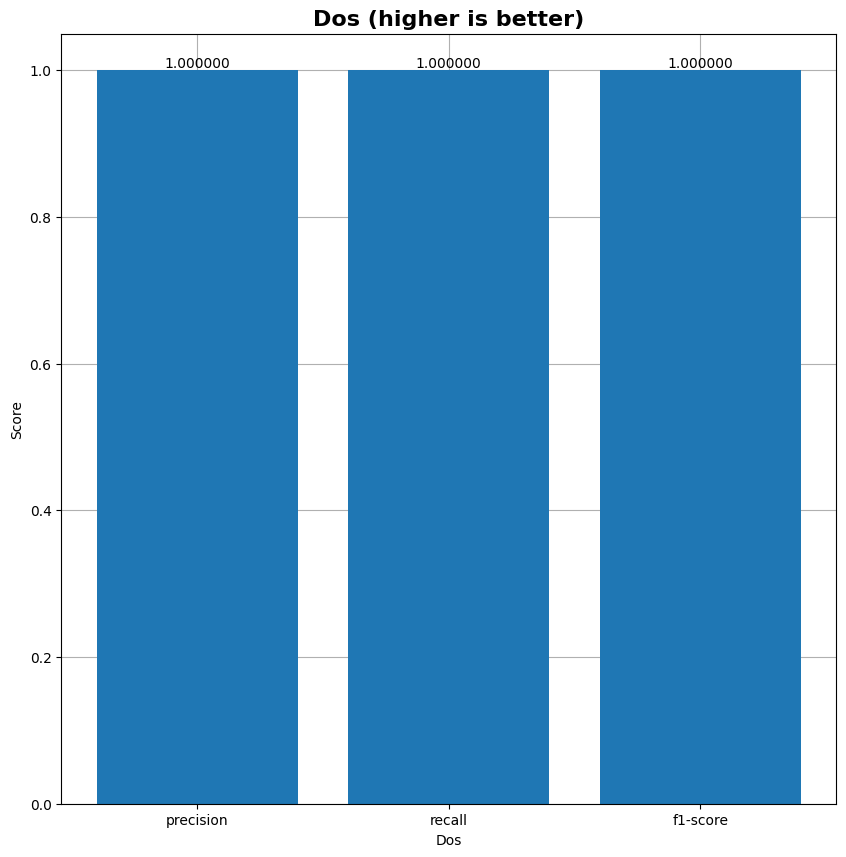

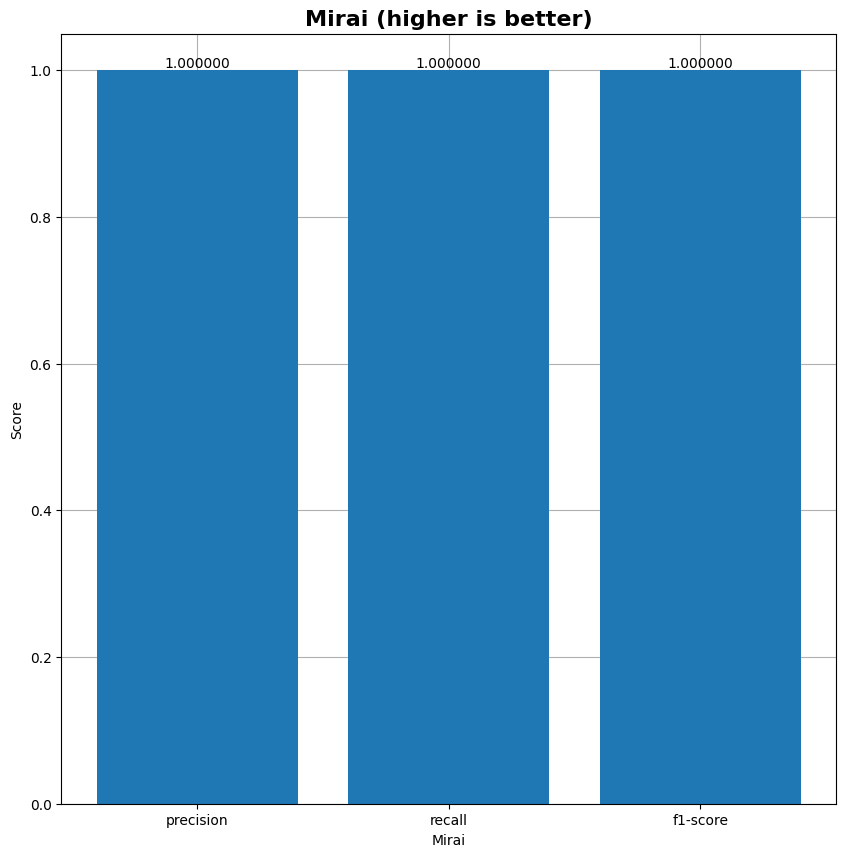

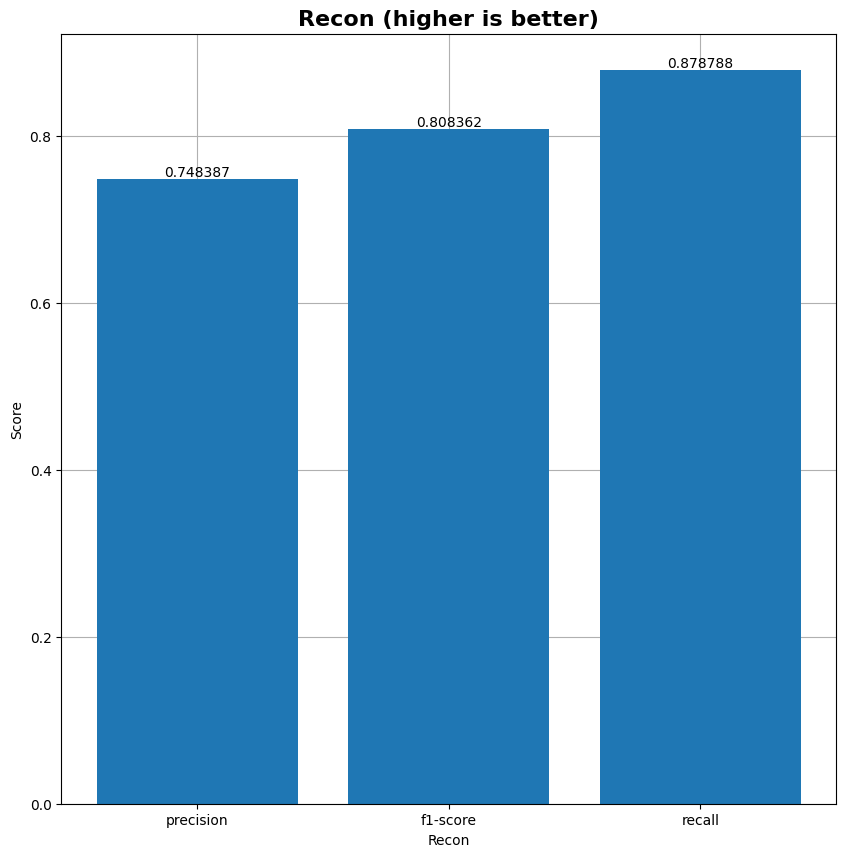

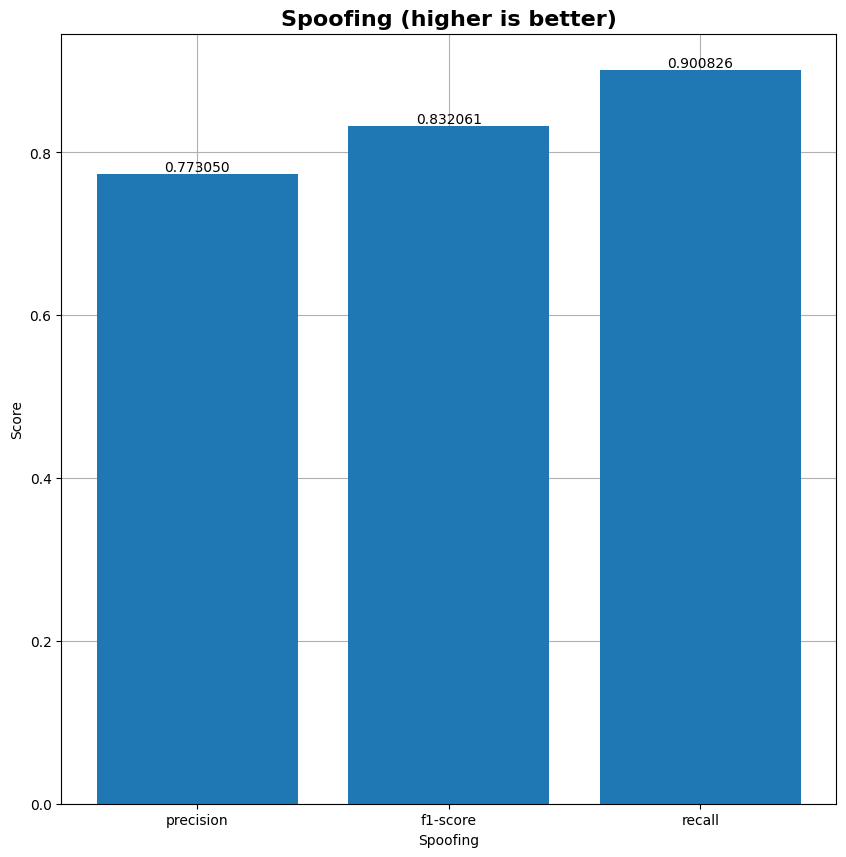

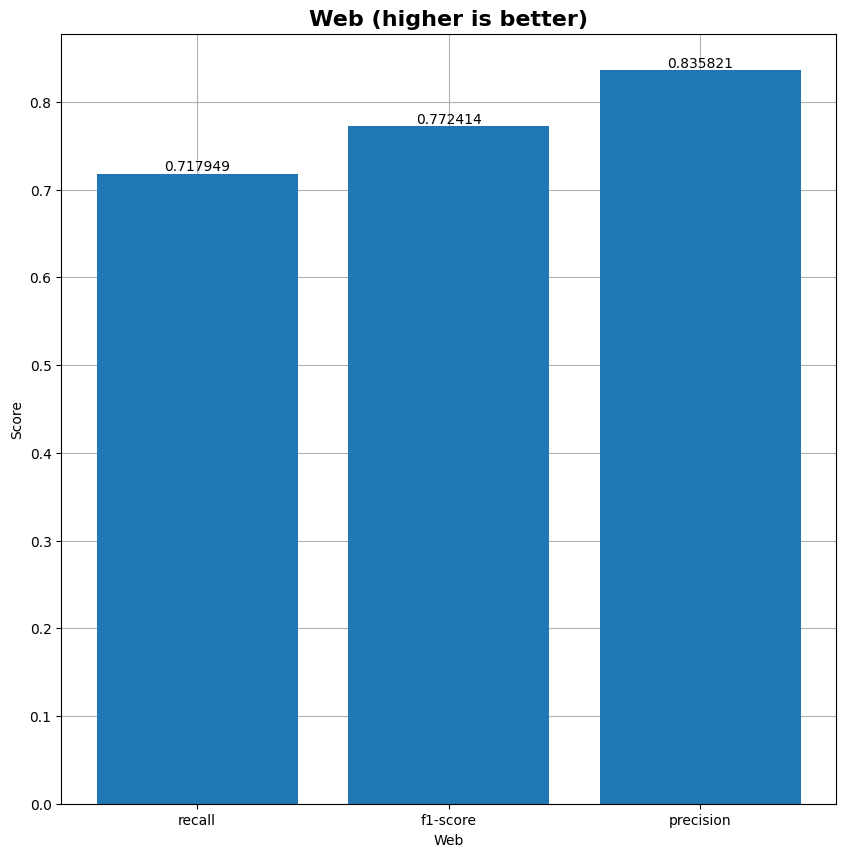

In [54]:
plot_mc(y_pred, y_test, "LightGBM")

In [55]:
model_name = "LightGBM_1000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Support Vector Machine

In [56]:
%%time

start = time.time()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

end = time.time()

SVM_Time = end - start

CPU times: user 9.61 s, sys: 26.5 ms, total: 9.63 s
Wall time: 9.69 s


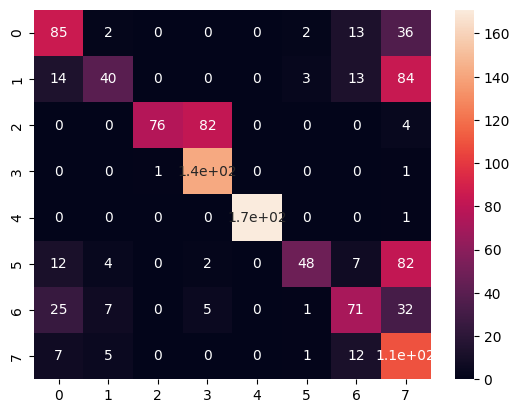

In [57]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [58]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [59]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, SVM_Time]
results_dict["SVM"] = results

In [60]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [61]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463
RF,0.853333,0.860908,0.852851,0.853333,0.833467,0.579167,2.920833,1.709045,0.446966
XGBoost,0.887500,0.893127,0.887680,0.887500,0.872146,0.440000,2.223333,1.491085,3.434732
LightGBM,0.888333,0.893065,0.888502,0.888333,0.872943,0.466667,2.396667,1.548117,1.122775
SVM,0.618333,0.726730,0.612024,0.618333,0.584289,1.353333,6.918333,2.630272,9.690726


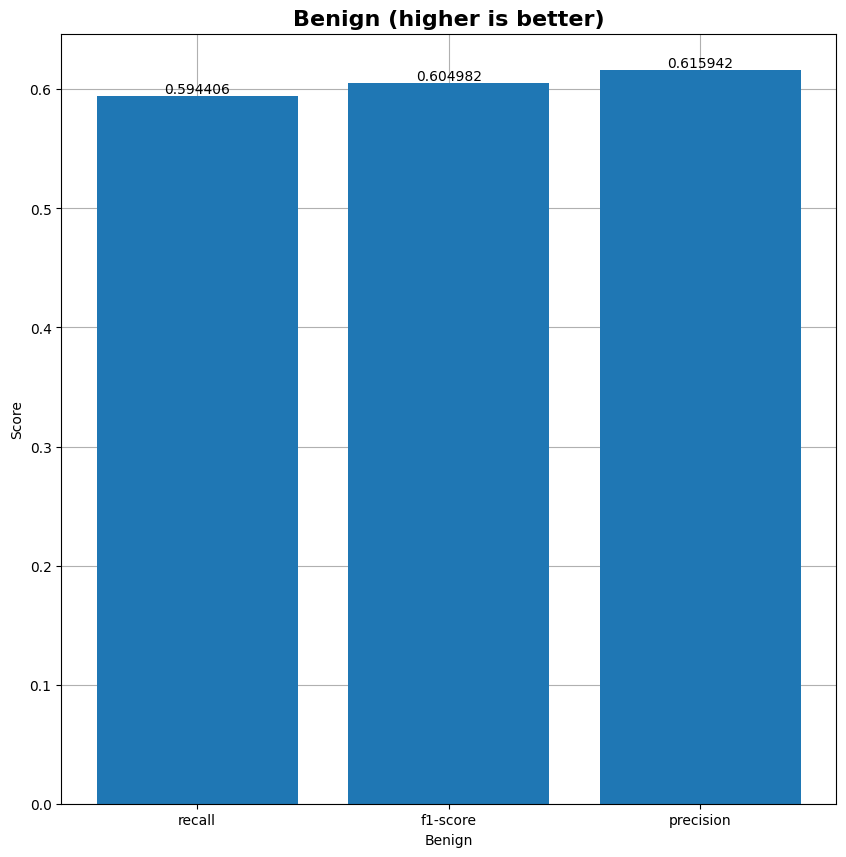

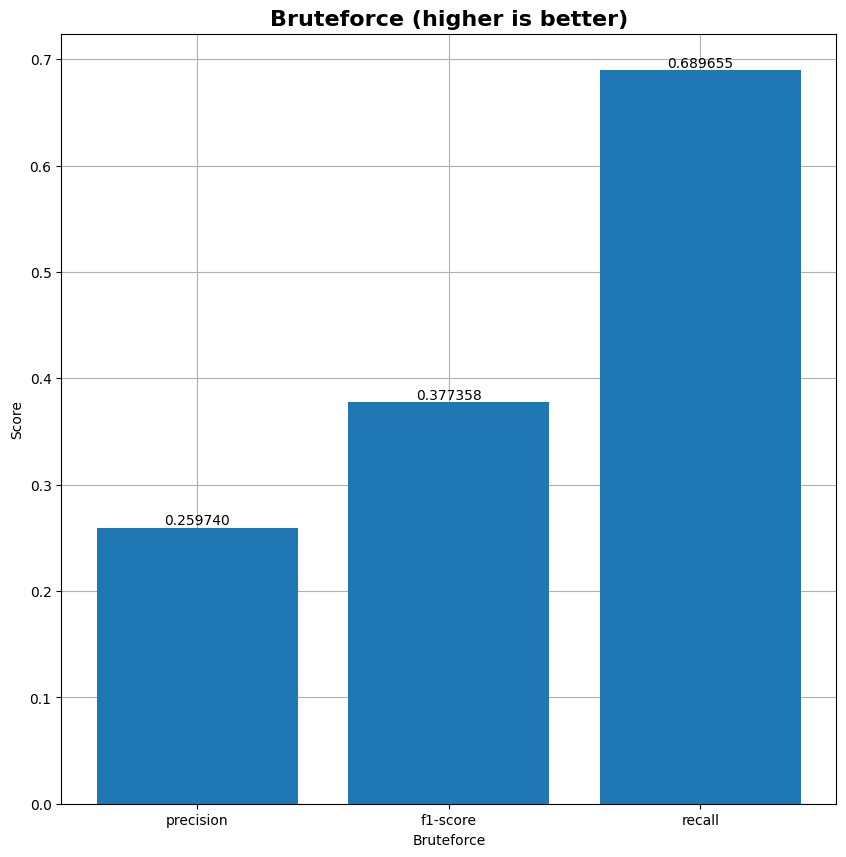

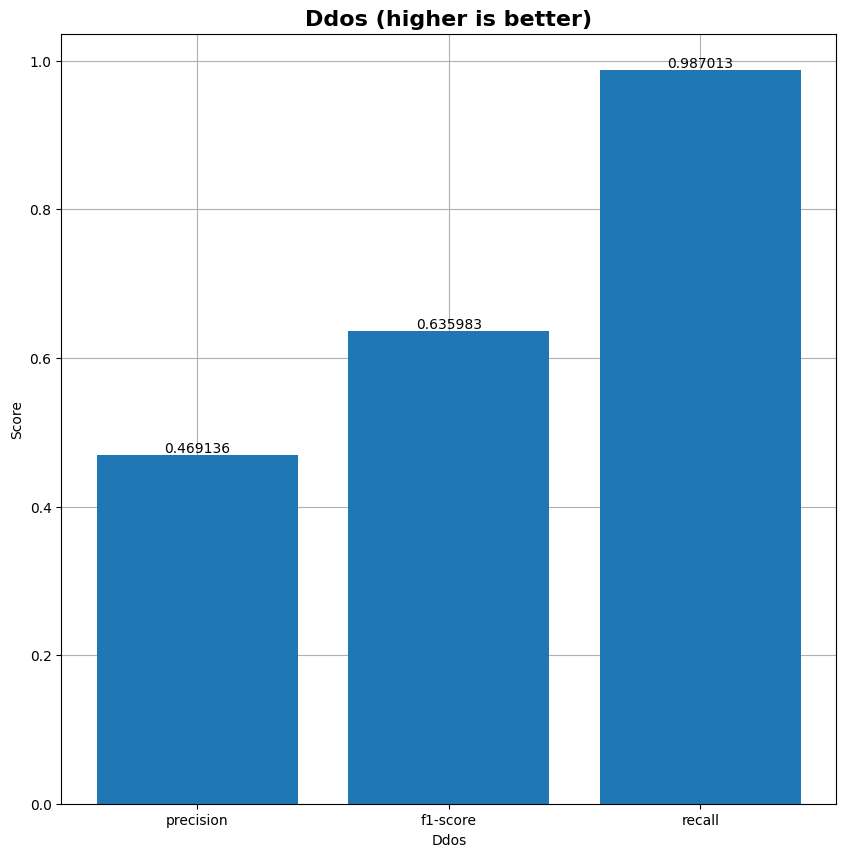

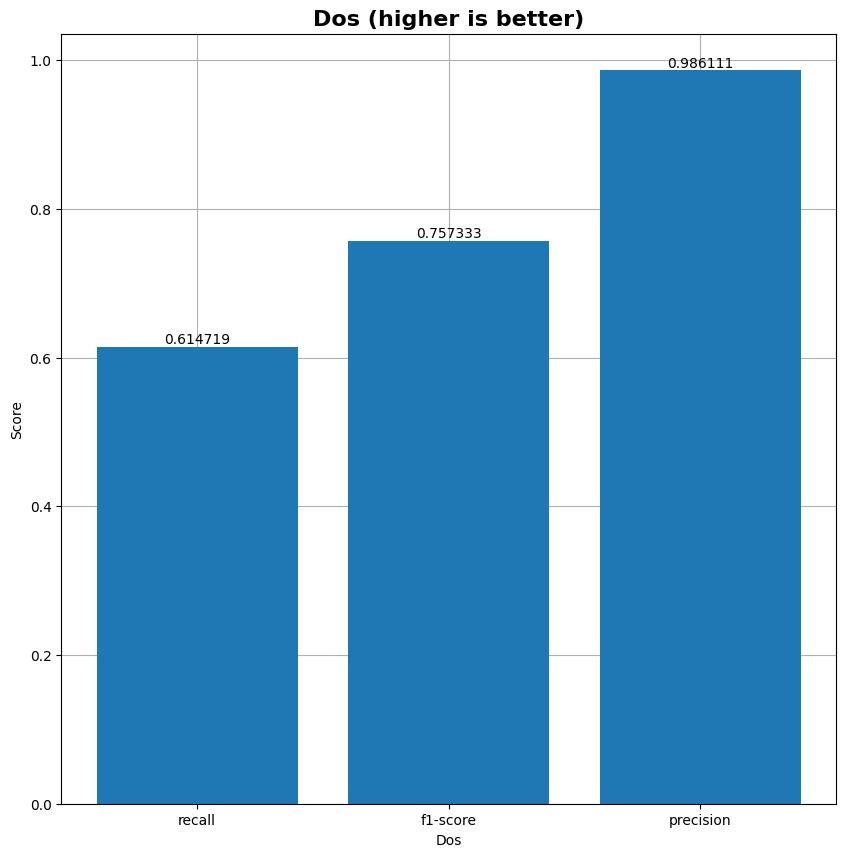

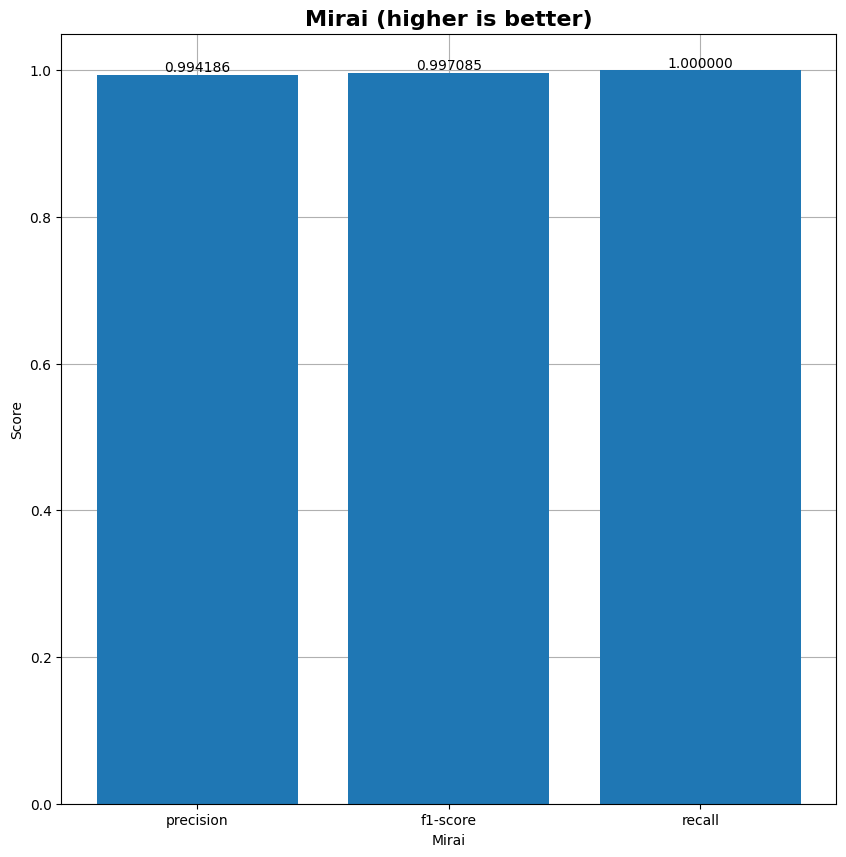

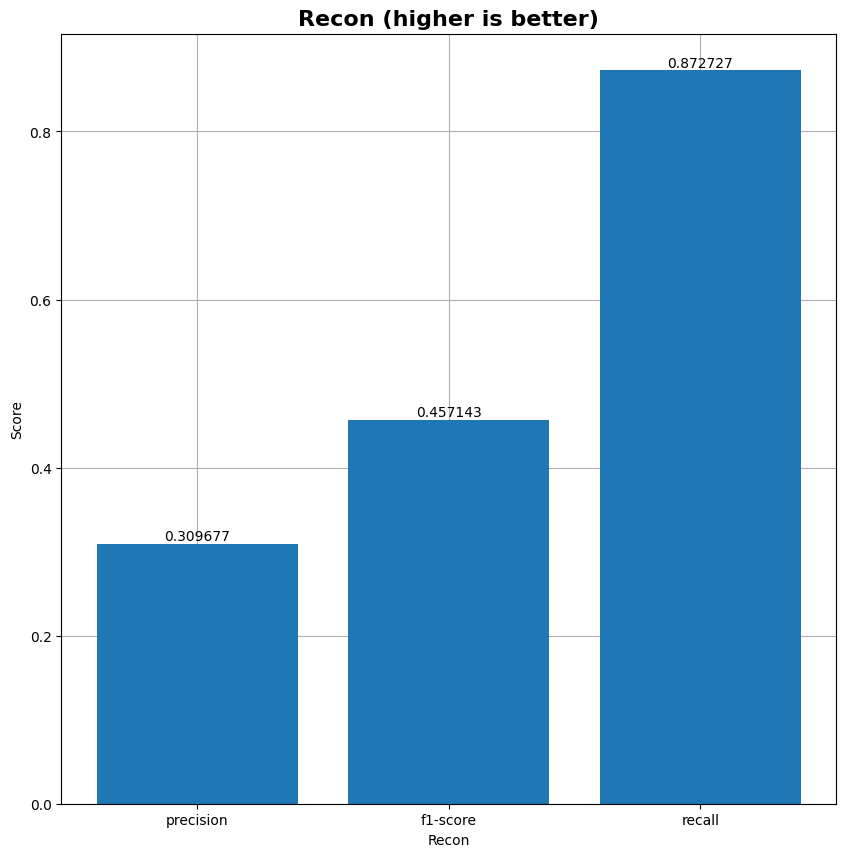

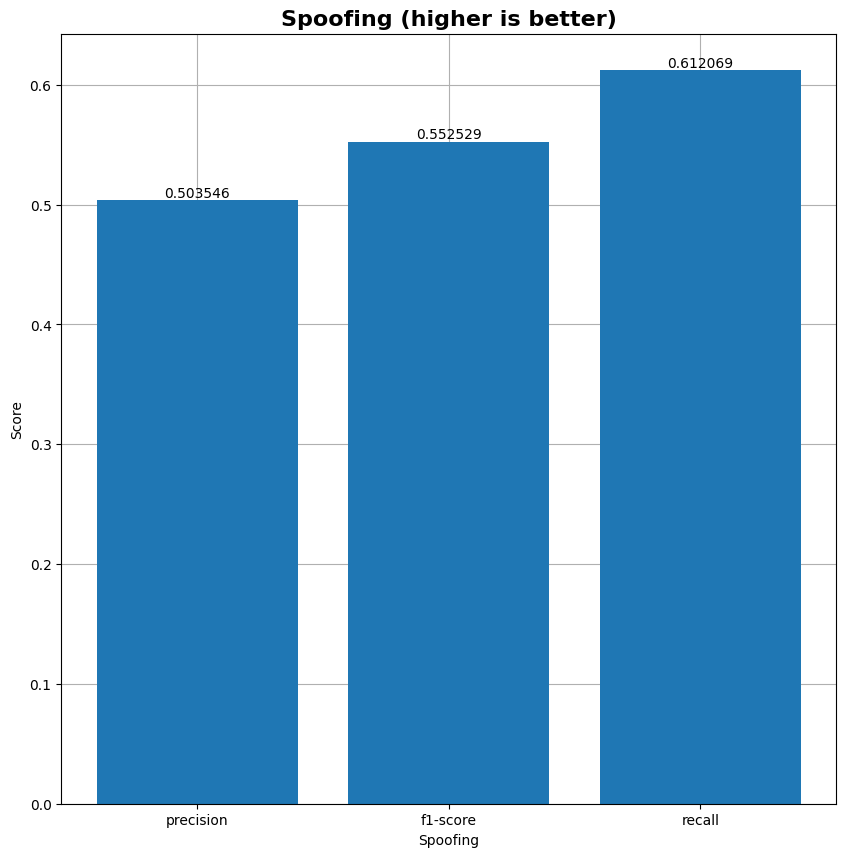

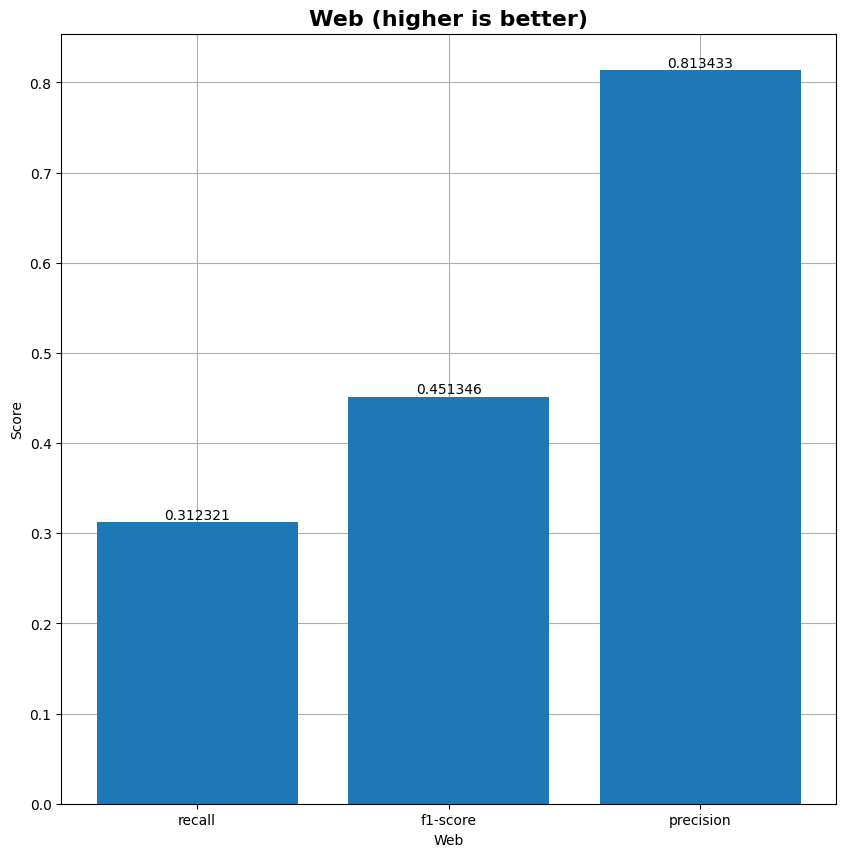

In [62]:
plot_mc(y_pred, y_test, "SVM")

In [63]:
model_name = "SVM_1000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5576, 46), (5576,), (1224, 46), (1224,), (1200, 46), (1200,))

In [65]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744696800.173403   60487 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5127 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [66]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744696803.680234   61477 service.cc:152] XLA service 0x7abdb000a660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744696803.680267   61477 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-15 09:00:03.738735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744696804.075230   61477 cuda_dnn.cc:529] Loaded cuDNN version 90300


 52/349 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4064 - loss: 1.6013

I0000 00:00:1744696805.310287   61477 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


349/349 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5319 - loss: 1.1882 - val_accuracy: 0.5964 - val_loss: 0.9038
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6228 - loss: 0.8724 - val_accuracy: 0.6258 - val_loss: 0.8473
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6568 - loss: 0.8061 - val_accuracy: 0.6773 - val_loss: 0.8097
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6630 - loss: 0.7731 - val_accuracy: 0.6838 - val_loss: 0.7862
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6858 - loss: 0.7302 - val_accuracy: 0.6871 - val_loss: 0.7748
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6960 - loss: 0.7113 - val_accuracy: 0.6773 - val_loss: 0.7760
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6944 - loss: 0.7307 - val_accuracy: 0.6920 - val_loss: 0.7755
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7194 - loss: 0.6612 - val_accuracy: 0.6691 - val_

In [68]:
y_pred = np.argmax(y_pred, axis=1)

In [69]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6775 - loss: 0.9738   


In [70]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [71]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [72]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463
RF,0.853333,0.860908,0.852851,0.853333,0.833467,0.579167,2.920833,1.709045,0.446966
XGBoost,0.887500,0.893127,0.887680,0.887500,0.872146,0.440000,2.223333,1.491085,3.434732
LightGBM,0.888333,0.893065,0.888502,0.888333,0.872943,0.466667,2.396667,1.548117,1.122775
SVM,0.618333,0.726730,0.612024,0.618333,0.584289,1.353333,6.918333,2.630272,9.690726
FF-NN,0.684167,0.703068,0.686507,0.684167,0.640379,1.184167,6.080833,2.465935,29.290822


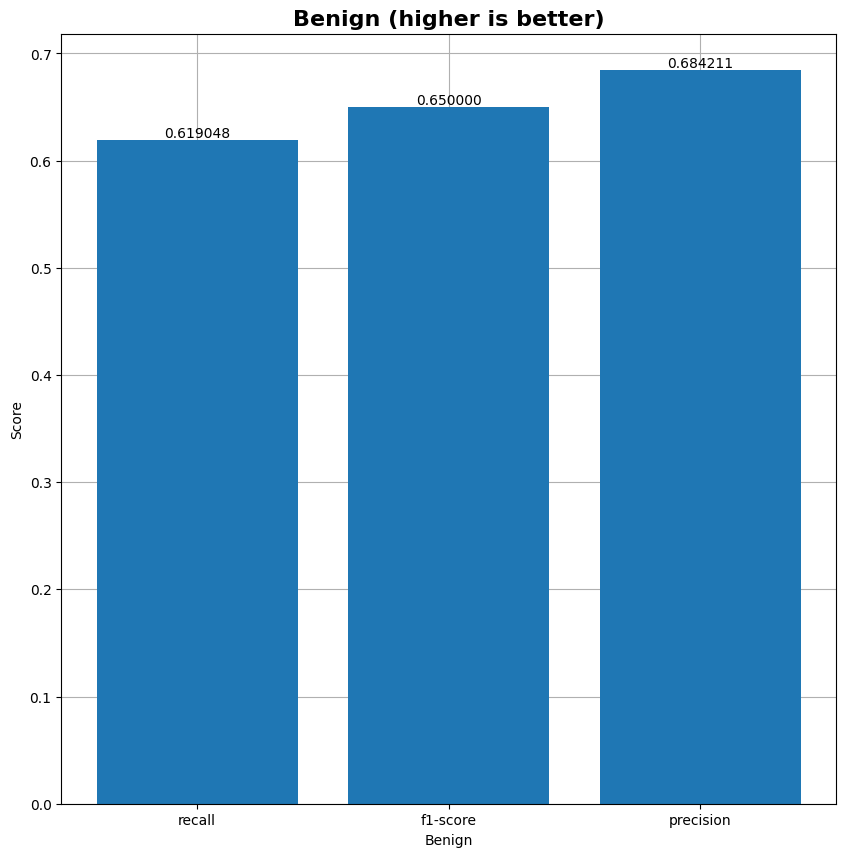

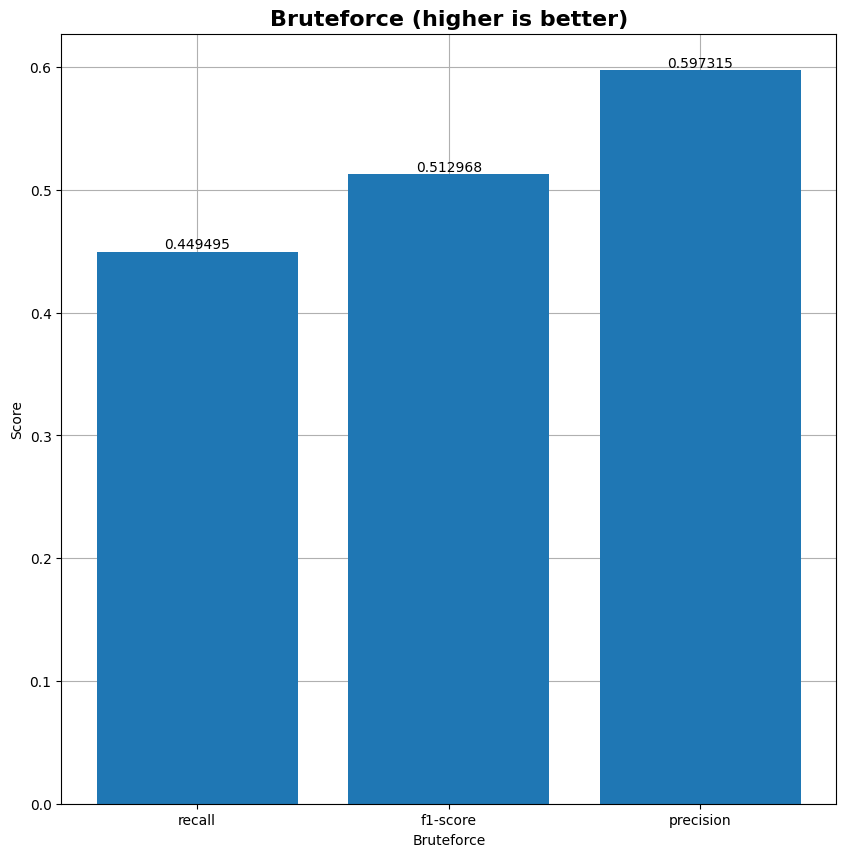

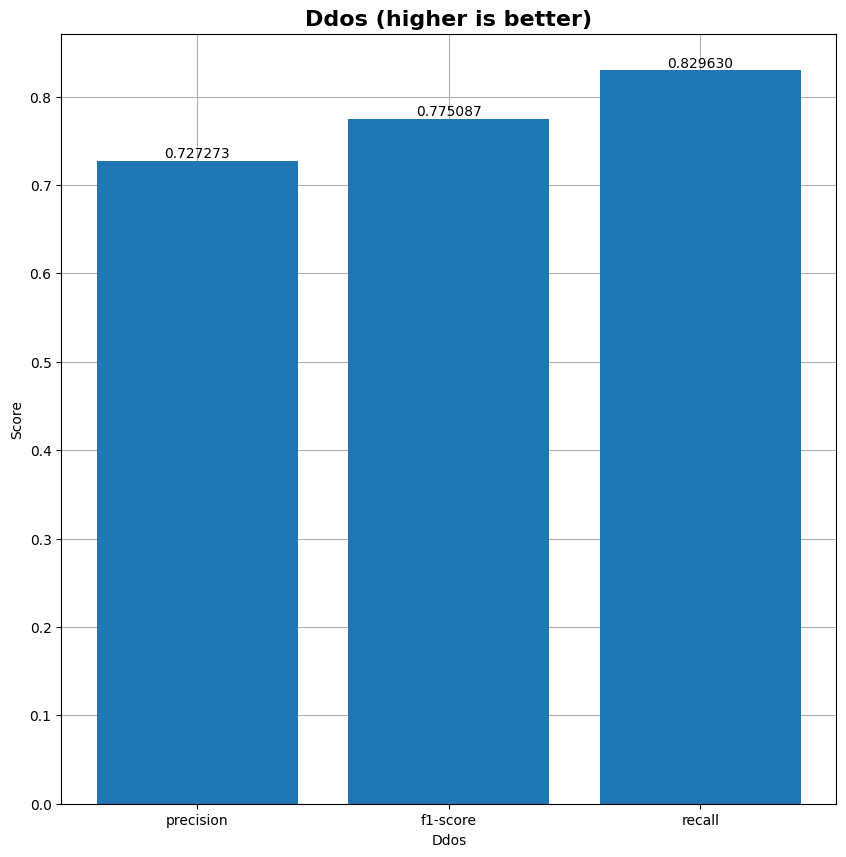

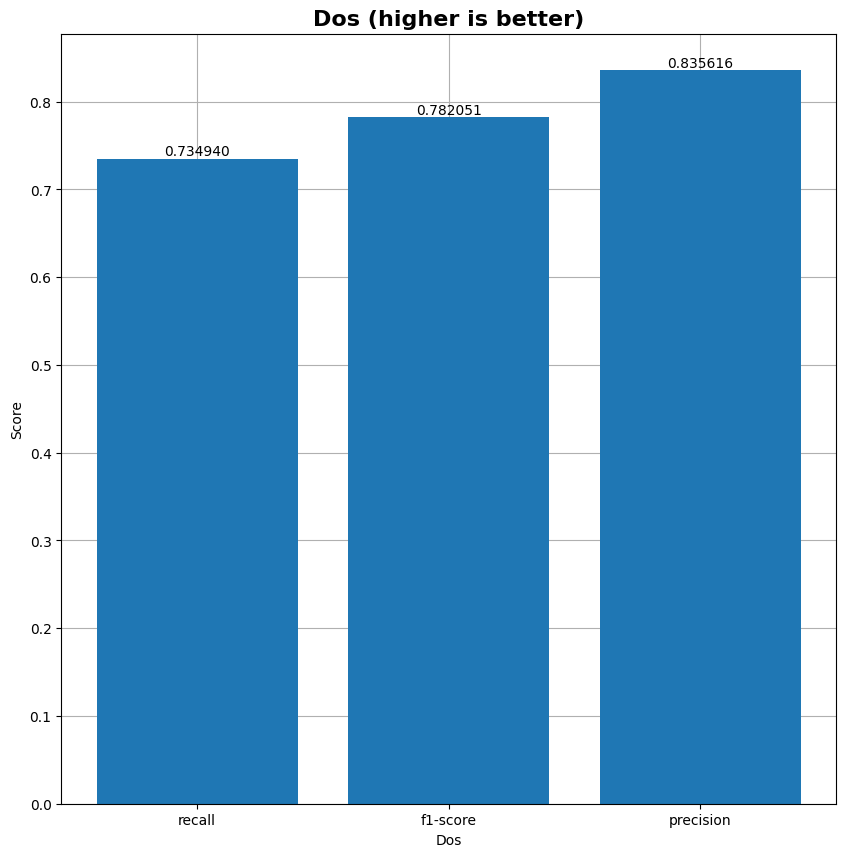

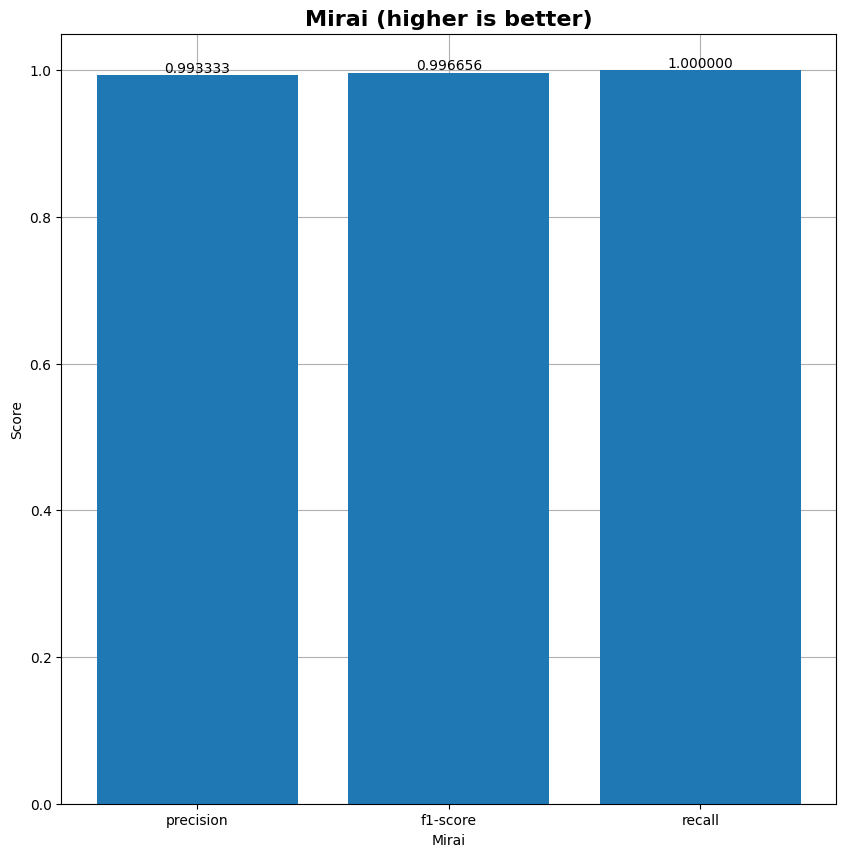

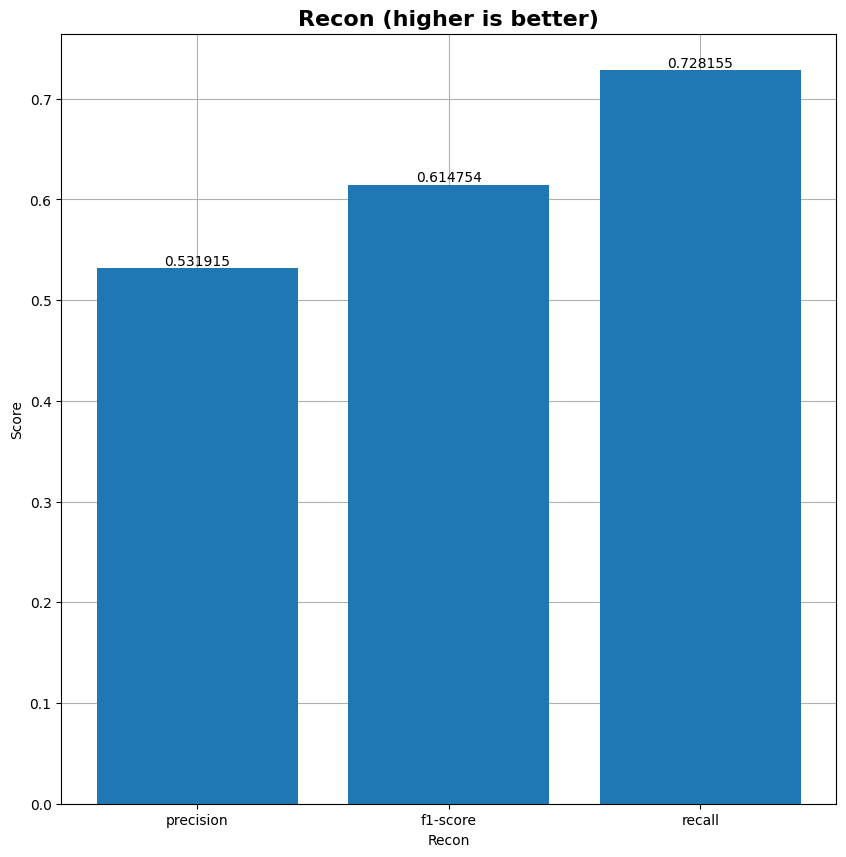

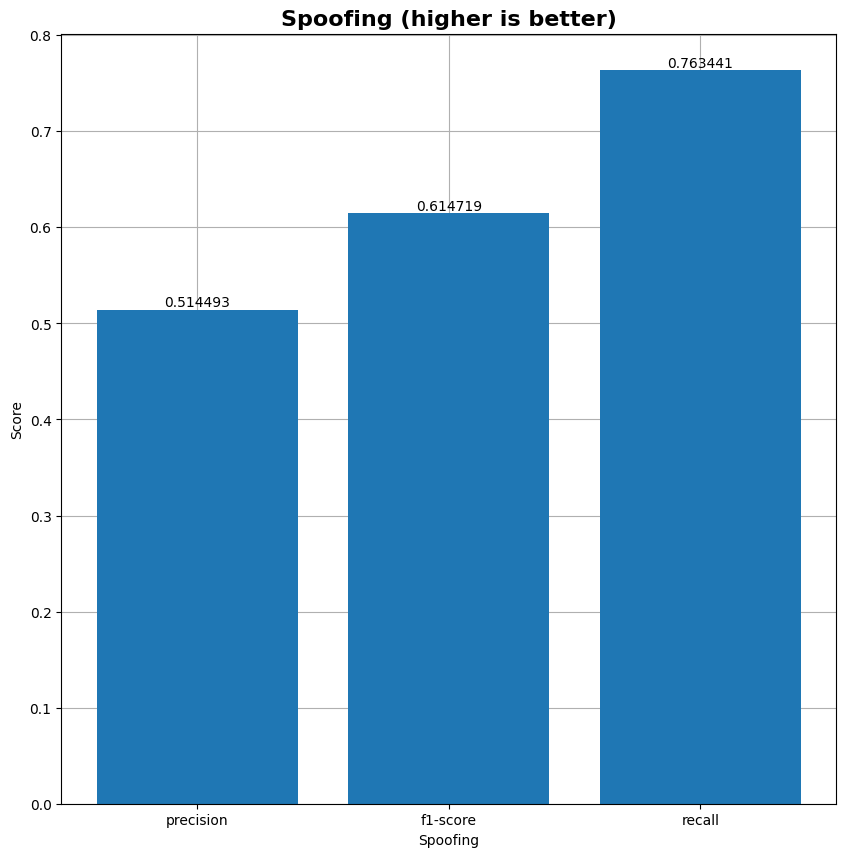

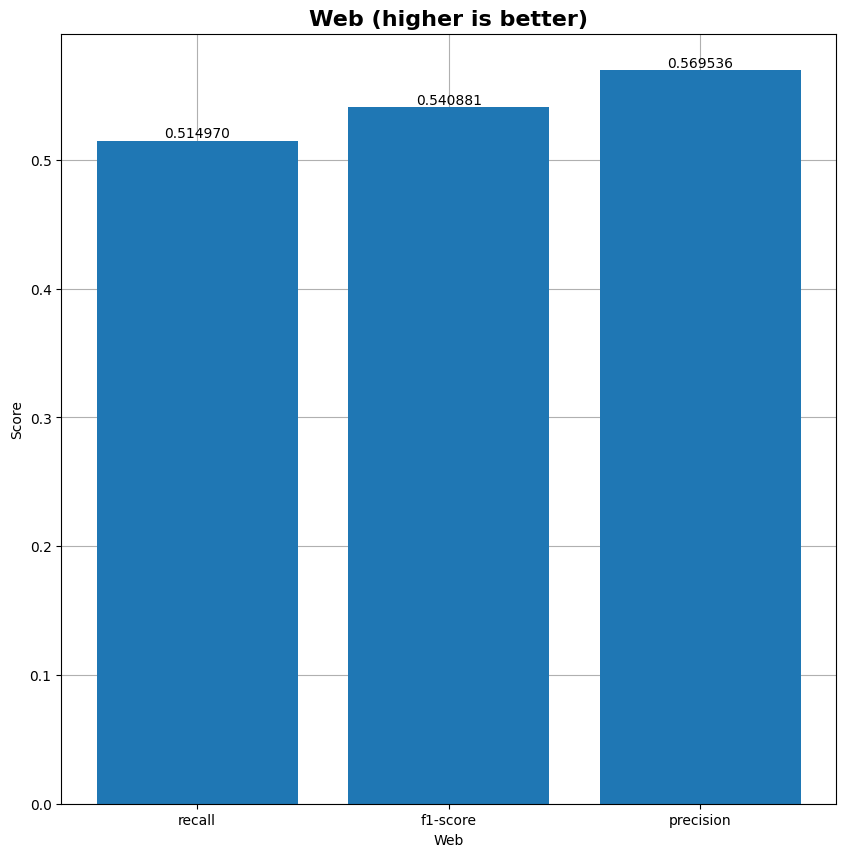

In [73]:
plot_mc(y_pred, y_test, "FF-NN")

In [74]:
model_name = "FFNN_1000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [75]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [76]:
num_components = len(np.unique(y))

In [77]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [78]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [79]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [80]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6988 - loss: 1.1343 - val_accuracy: 0.9891 - val_loss: 0.0598
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9891 - loss: 0.0648 - val_accuracy: 0.9925 - val_loss: 0.0462
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9921 - loss: 0.0350 - val_accuracy: 0.9933 - val_loss: 0.0371
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9971 - loss: 0.0143 - val_accuracy: 0.9958 - val_loss: 0.0301
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9956 - loss: 0.0184 - val_accuracy: 0.9958 - val_loss: 0.0332
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9984 - loss: 0.0075 - val_accuracy: 0.9942 - val_loss: 0.0368
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9953 - loss: 0.0155 - val_accuracy: 0.9958 - val_loss: 0.0334
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9985 - loss: 0.0067 - val_accuracy: 0

In [83]:
_, accuracy = model.evaluate(X_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9963 - loss: 0.0100    


In [84]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [85]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [86]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [87]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [88]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.689167,0.701064,0.690169,0.689167,0.646142,1.235833,6.429167,2.535580,0.060391
LR,0.650833,0.666838,0.648839,0.650833,0.603831,1.211667,5.890000,2.426932,7.162463
RF,0.853333,0.860908,0.852851,0.853333,0.833467,0.579167,2.920833,1.709045,0.446966
XGBoost,0.887500,0.893127,0.887680,0.887500,0.872146,0.440000,2.223333,1.491085,3.434732
LightGBM,0.888333,0.893065,0.888502,0.888333,0.872943,0.466667,2.396667,1.548117,1.122775
SVM,0.618333,0.726730,0.612024,0.618333,0.584289,1.353333,6.918333,2.630272,9.690726
FF-NN,0.684167,0.703068,0.686507,0.684167,0.640379,1.184167,6.080833,2.465935,29.290822
LSTM,0.994987,0.995094,0.994991,0.994987,0.994283,0.021721,0.121972,0.349244,20.920261


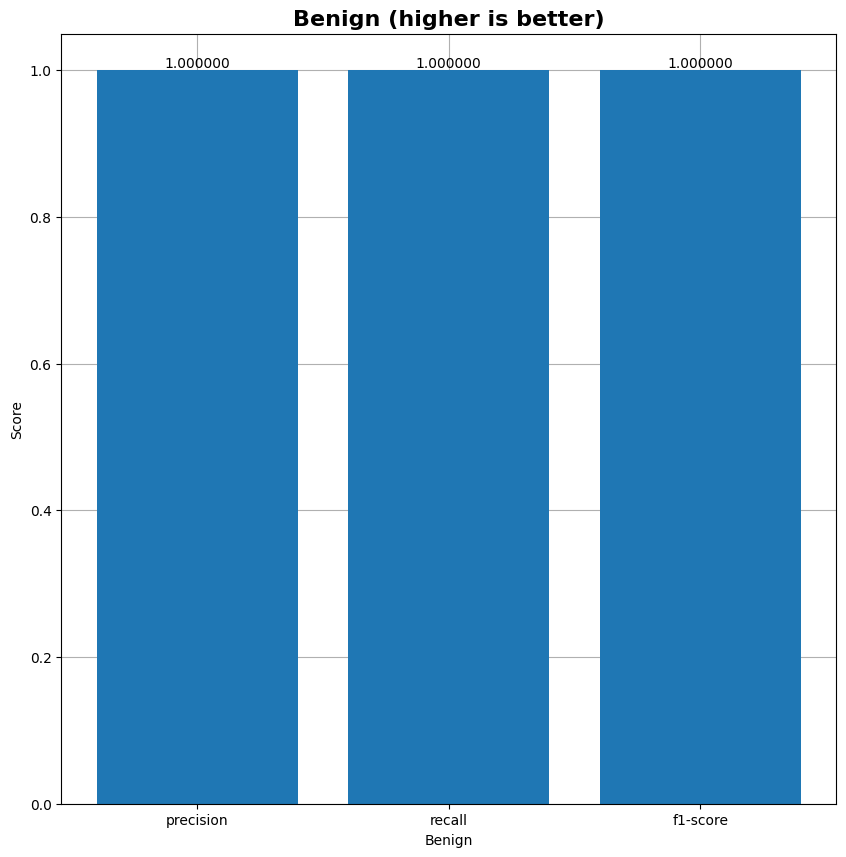

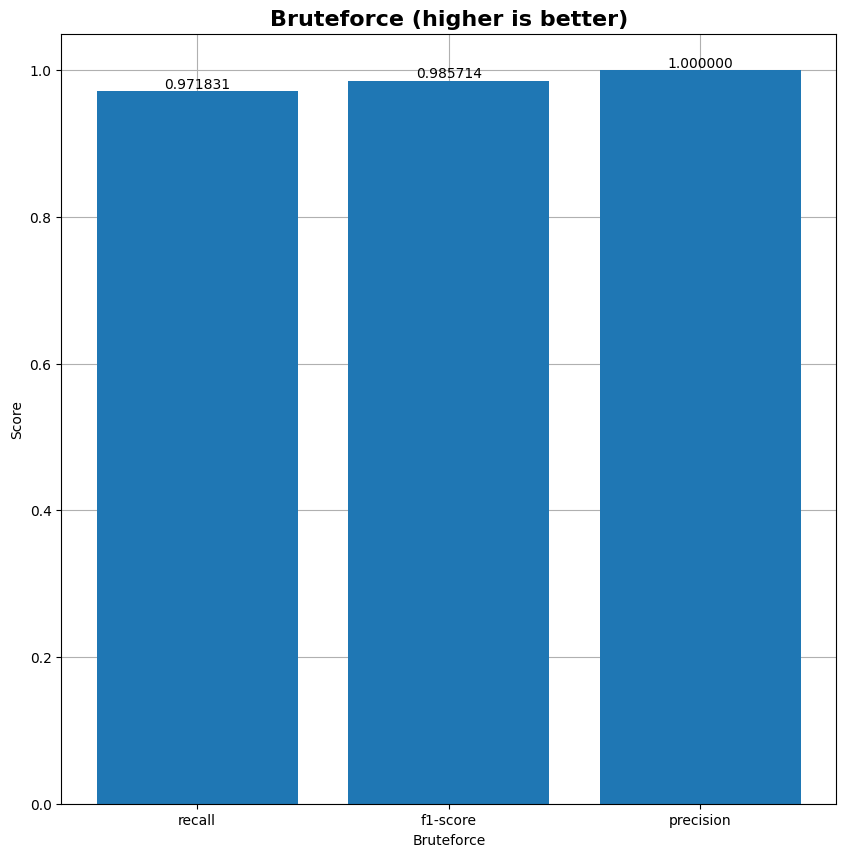

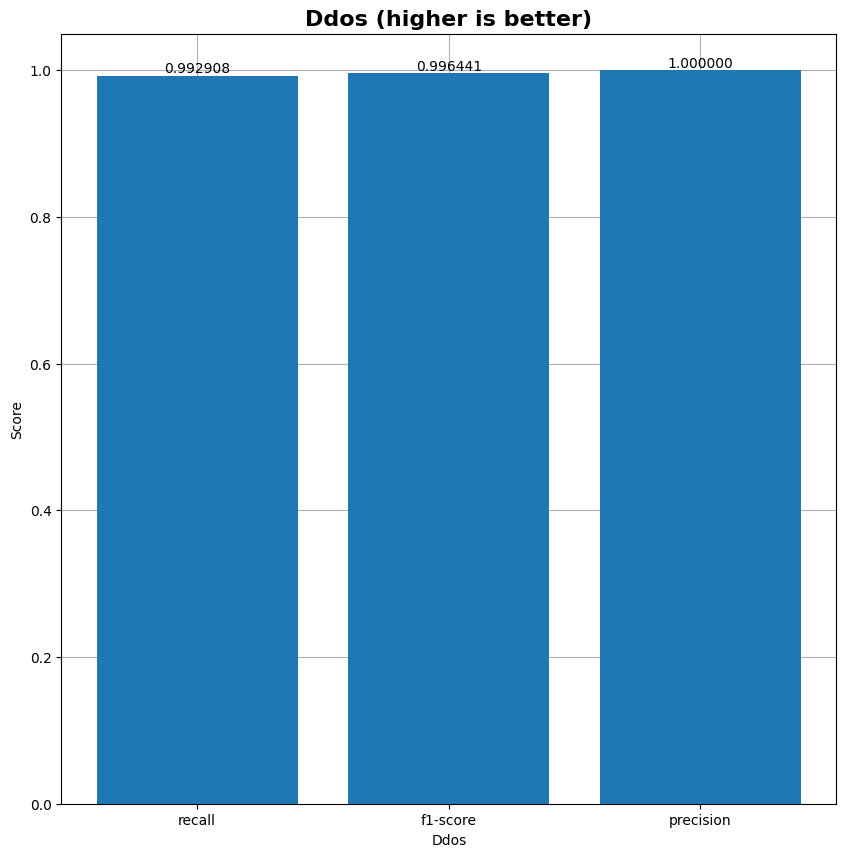

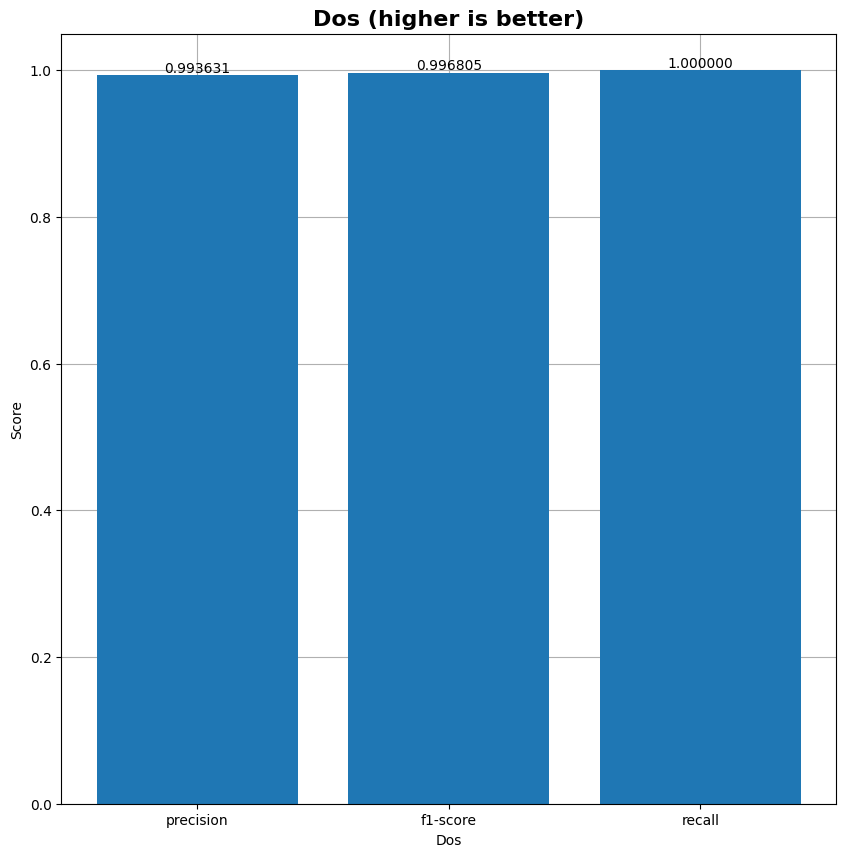

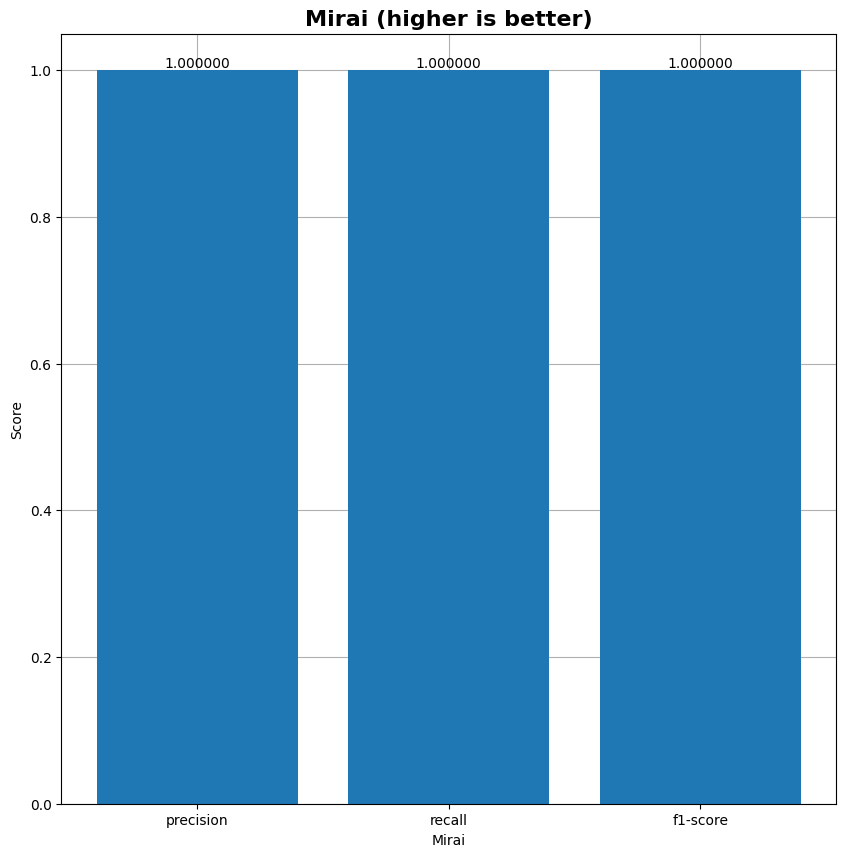

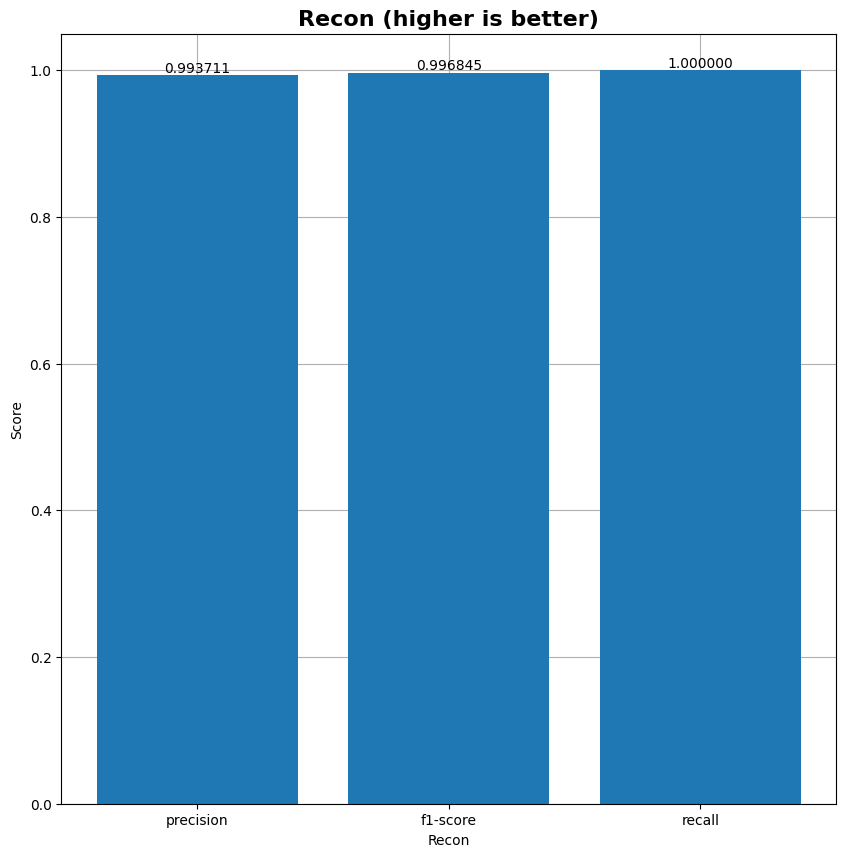

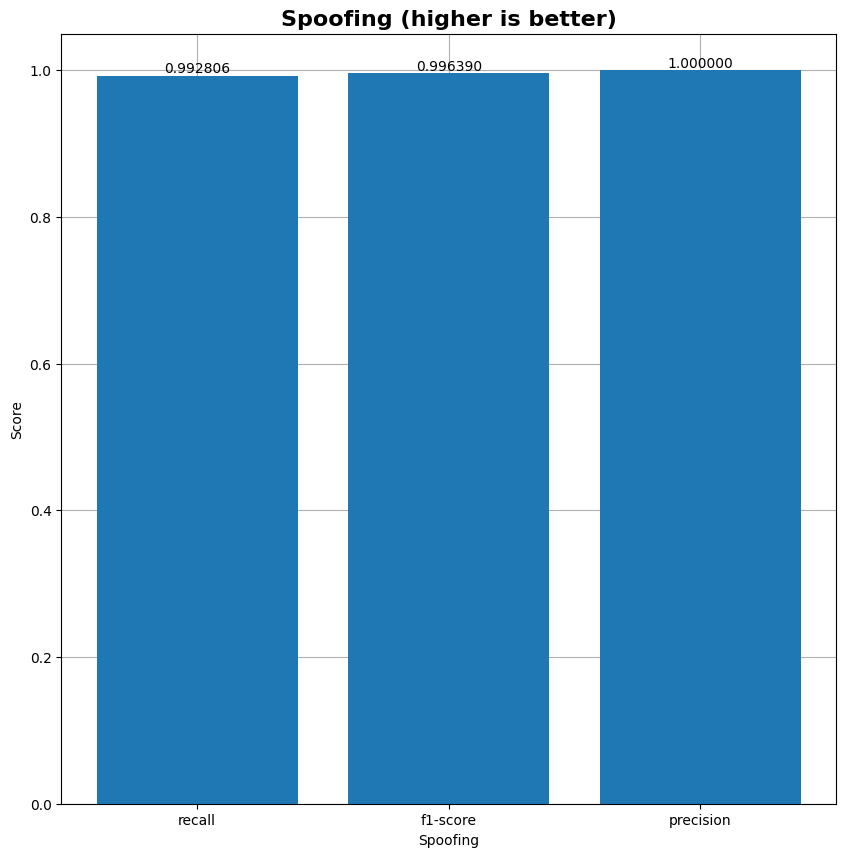

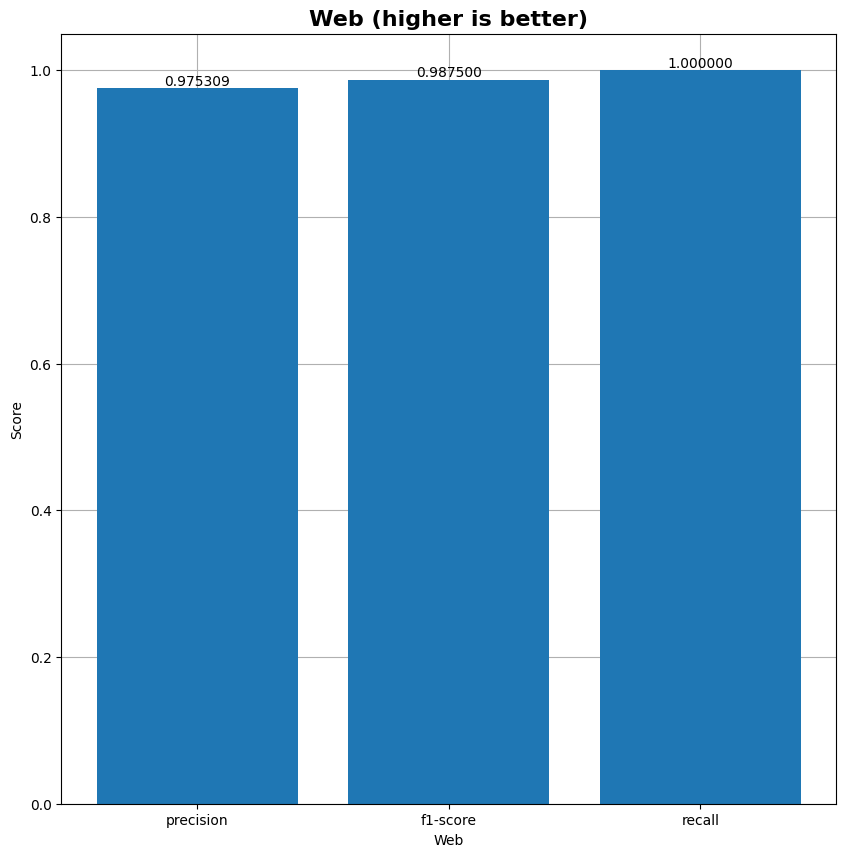

In [89]:
plot_mc(y_pred, y_test, "LSTM")

In [90]:
model_name = "LSTM_1000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

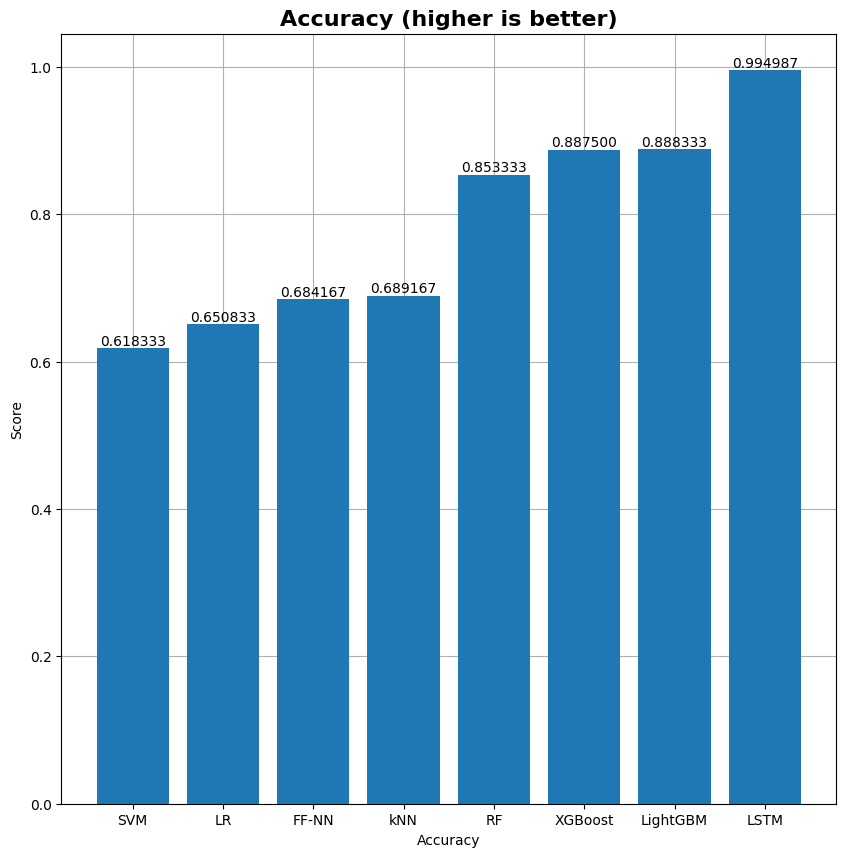

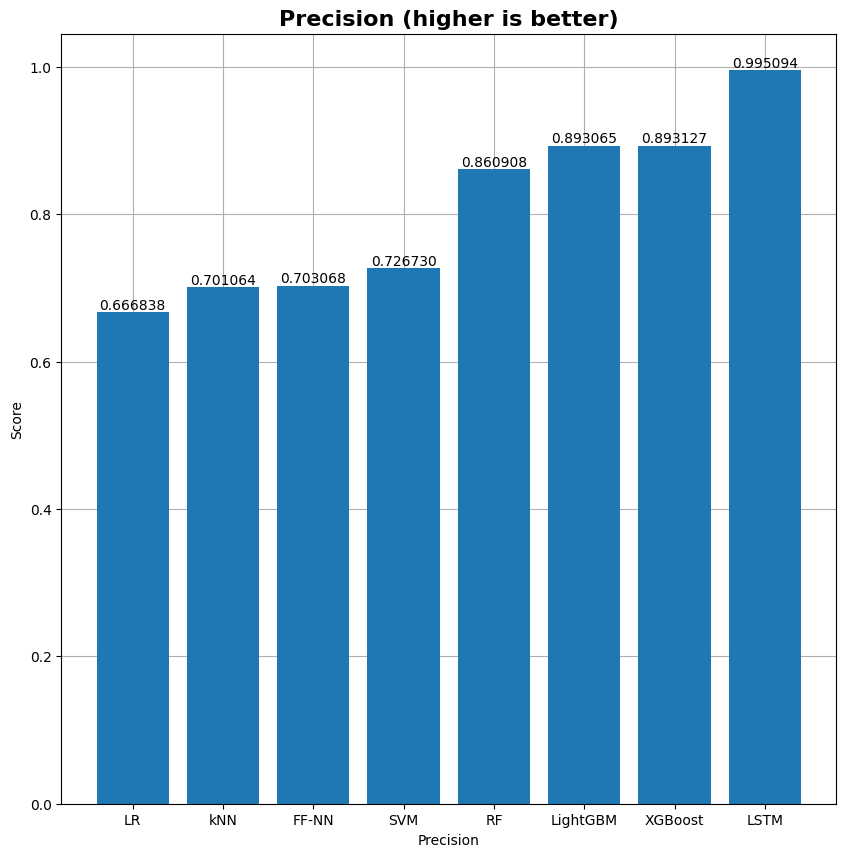

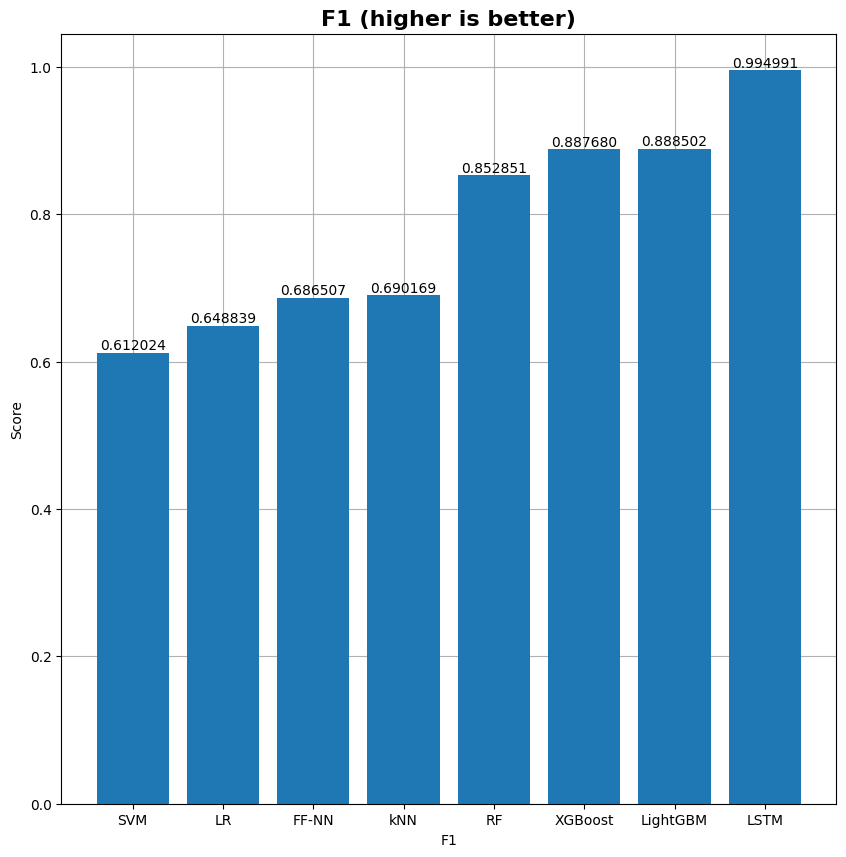

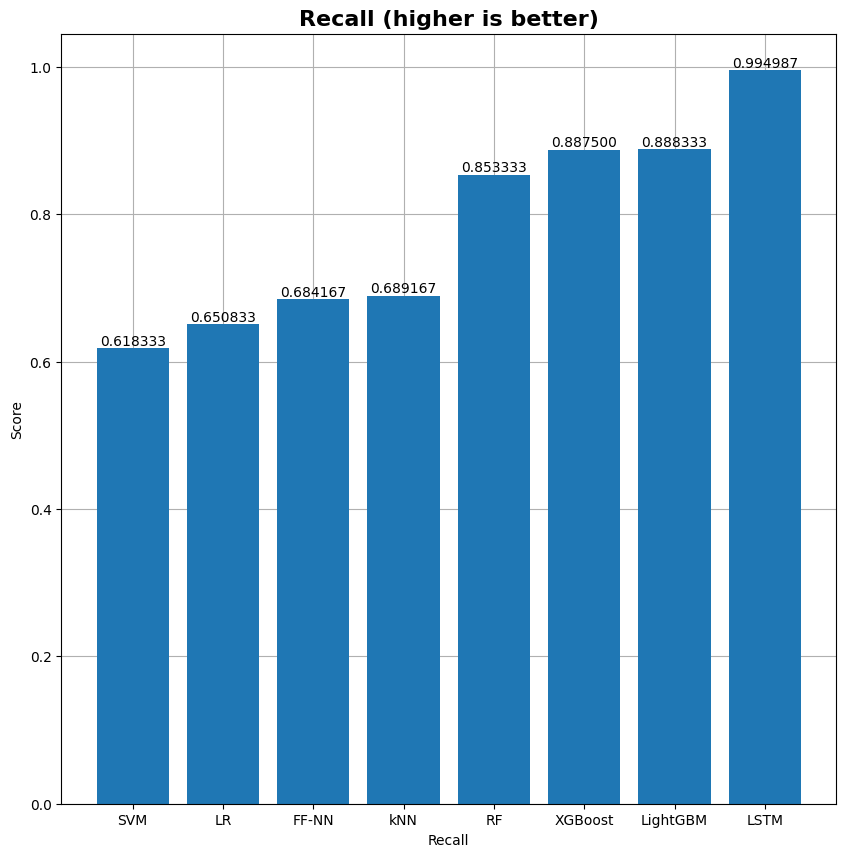

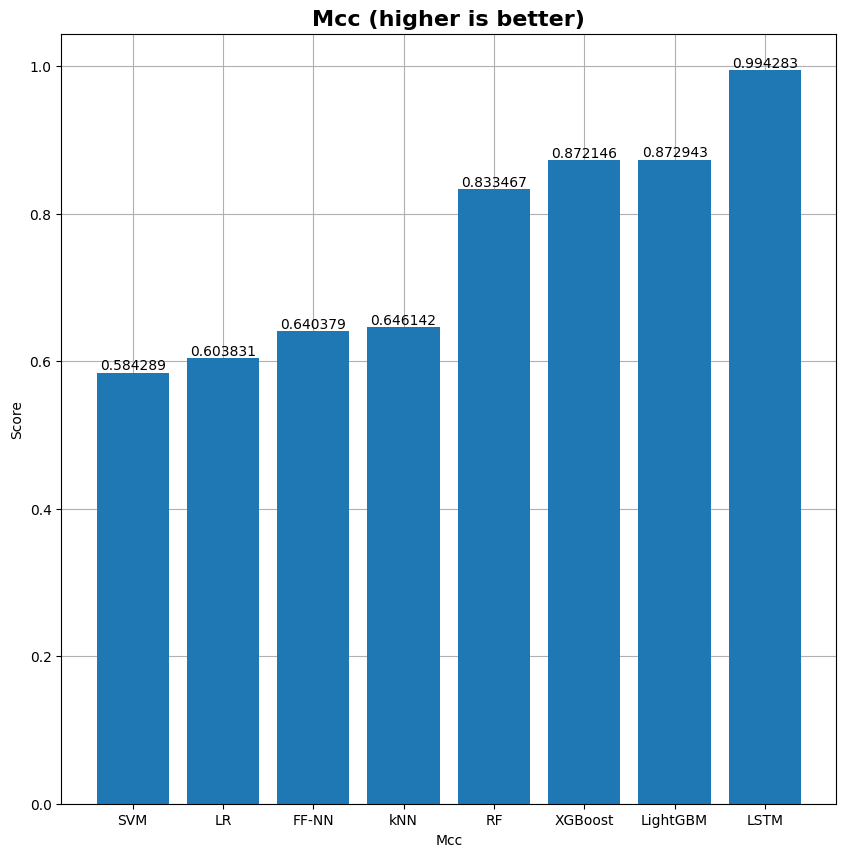

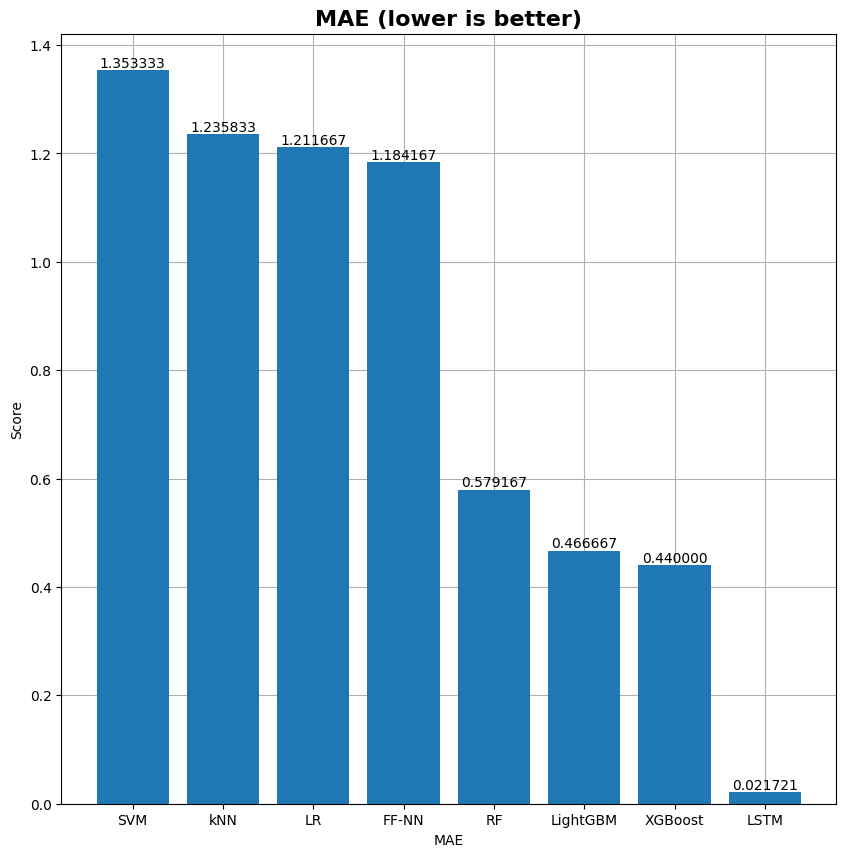

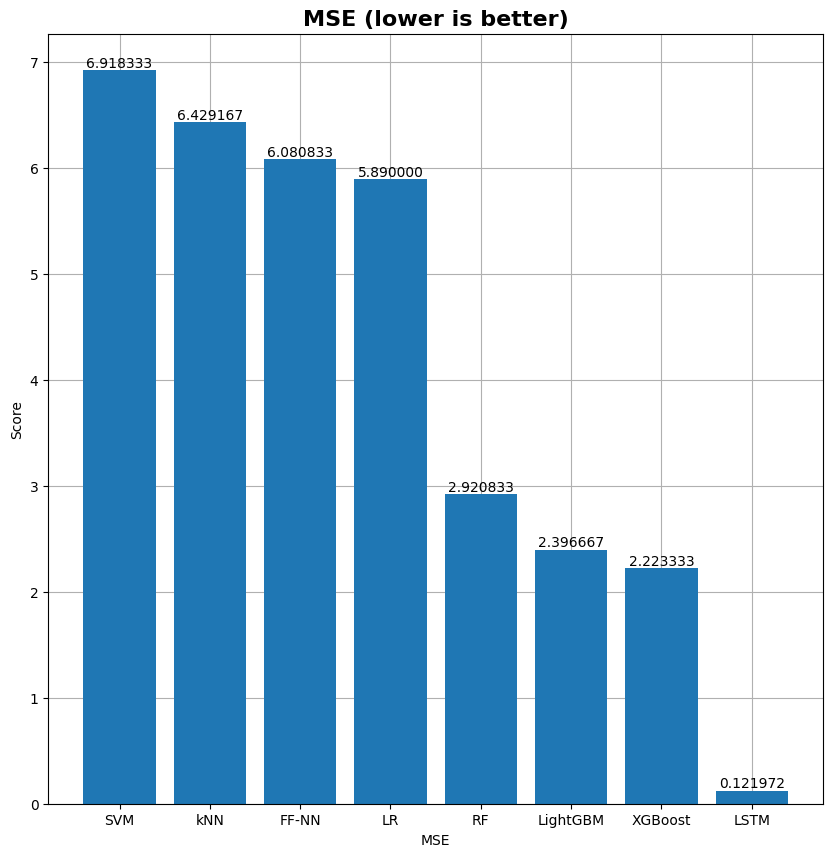

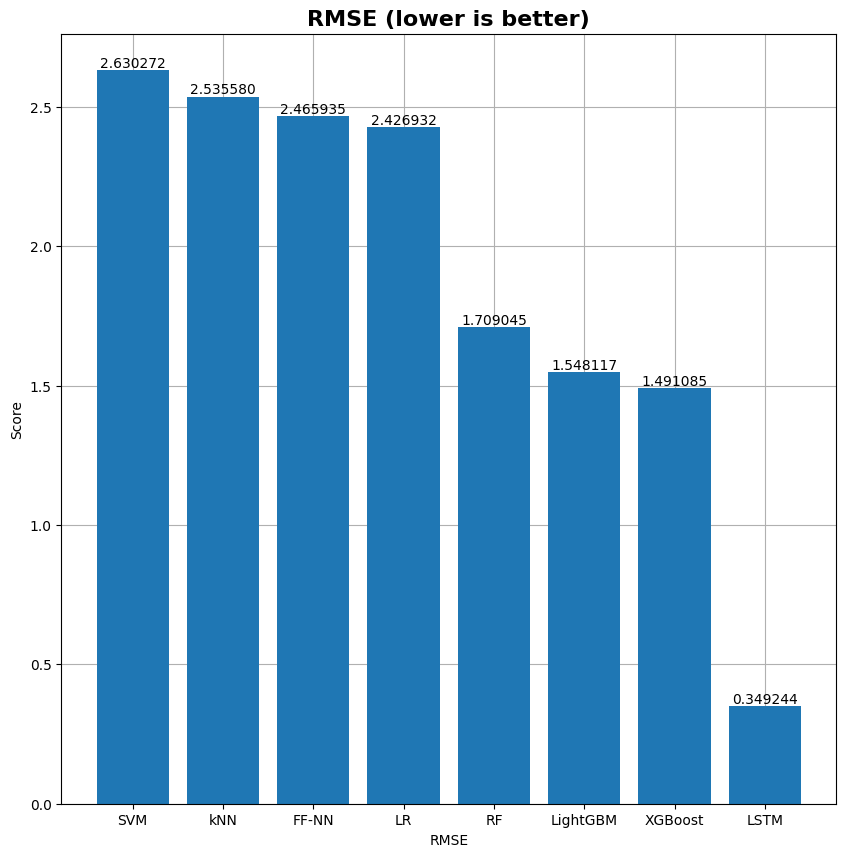

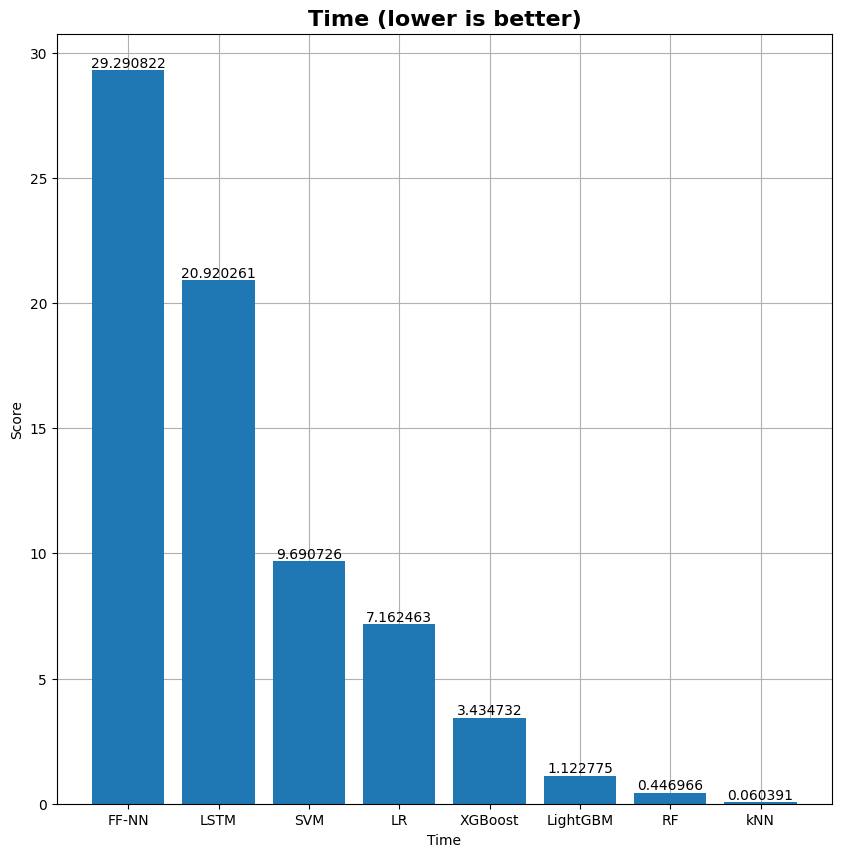

In [91]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [92]:
df_dict = results_df.to_dict()

In [93]:
values = ['Precision', 'Recall', 'F1']
new_dict = {}
for value in values:
    new_dict[value] = df_dict[value]

In [94]:
new_dict

{'Precision': {'kNN': 0.7010639448388554,
  'LR': 0.6668378363842126,
  'RF': 0.8609076215120706,
  'XGBoost': 0.8931268598890271,
  'LightGBM': 0.8930649663677988,
  'SVM': 0.726729922726057,
  'FF-NN': 0.7030677323152879,
  'LSTM': 0.9950935359227434},
 'Recall': {'kNN': 0.6891666666666667,
  'LR': 0.6508333333333334,
  'RF': 0.8533333333333334,
  'XGBoost': 0.8875,
  'LightGBM': 0.8883333333333333,
  'SVM': 0.6183333333333333,
  'FF-NN': 0.6841666666666667,
  'LSTM': 0.9949874686716792},
 'F1': {'kNN': 0.6901694559016293,
  'LR': 0.6488389920801715,
  'RF': 0.8528508650464804,
  'XGBoost': 0.8876797221659564,
  'LightGBM': 0.8885018182936847,
  'SVM': 0.6120238932618434,
  'FF-NN': 0.6865065550582642,
  'LSTM': 0.9949907945789457}}

In [95]:
pd.DataFrame(new_dict).transpose()

,kNN,LR,RF,XGBoost,LightGBM,SVM,FF-NN,LSTM
Precision,0.701064,0.666838,0.860908,0.893127,0.893065,0.726730,0.703068,0.995094
Recall,0.689167,0.650833,0.853333,0.887500,0.888333,0.618333,0.684167,0.994987
F1,0.690169,0.648839,0.852851,0.887680,0.888502,0.612024,0.686507,0.994991
